# Executive Summary

Goals: Build a classification model to analyze the drivers of an outcome for a UFC fight

Best Features: 

Takeaways: N/A

In [1]:
#imports
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from wrangle import train_validate_test_split,impute_nulls, split_X_y  
from explore import explore_univariate, get_ufc_heatmap
from acquire import summarize_df
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import statsmodels.api as sm
import sklearn.metrics
from sklearn.metrics import explained_variance_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm, naive_bayes

# Acquire 

In [2]:
## acquire our data from our local csv

df = pd.read_csv('data.csv', index_col=0) ## reading our csv into a pandas dataframe

df.head() ## previewing our data

B_fighter        Referee        date  \
R_fighter                                                     
Adrian Yanez       Gustavo Lopez  Chris Tognoni  2021-03-20   
Trevin Giles       Roman Dolidze      Herb Dean  2021-03-20   
Tai Tuivasa      Harry Hunsucker      Herb Dean  2021-03-20   
Cheyanne Buys  Montserrat Conejo     Mark Smith  2021-03-20   
Marion Reneau      Macy Chiasson     Mark Smith  2021-03-20   

                             location Winner  title_bout       weight_class  \
R_fighter                                                                     
Adrian Yanez   Las Vegas, Nevada, USA    Red       False       Bantamweight   
Trevin Giles   Las Vegas, Nevada, USA    Red       False       Middleweight   
Tai Tuivasa    Las Vegas, Nevada, USA    Red       False        Heavyweight   
Cheyanne Buys  Las Vegas, Nevada, USA   Blue       False   WomenStrawweight   
Marion Reneau  Las Vegas, Nevada, USA   Blue       False  WomenBantamweight   

               B_avg_KD  B_avg_opp_KD  B_avg_SIG_STR_pct  ...  \
R_fighter                                                 ...   
Adrian Yanez      0.000           0.0           0.420000  ...   
Trevin Giles      0.500           0.0           0.660000  ...   
Tai Tuivasa         NaN           NaN                NaN  ...   
Cheyanne Buys       NaN           NaN                NaN  ...   
Marion Reneau     0.125           0.0           0.535625  ...   

               R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
R_fighter                                                     
Adrian Yanez                             0                1   
Trevin Giles                             0                3   
Tai Tuivasa                              1                3   
Cheyanne Buys                            0                0   
Marion Reneau                            1                2   

               R_win_by_Submission  R_win_by_TKO_Doctor_Stoppage  R_Stance  \
R_fighter                                                                    
Adrian Yanez                     0                             0  Orthodox   
Trevin Giles                     0                             0  Orthodox   
Tai Tuivasa                      0                             0  Southpaw   
Cheyanne Buys                    0                             0    Switch   
Marion Reneau                    2                             0  Orthodox   

               R_Height_cms  R_Reach_cms  R_Weight_lbs  B_age  R_age  
R_fighter                                                             
Adrian Yanez         170.18       177.80         135.0   31.0   27.0  
Trevin Giles         182.88       187.96         185.0   32.0   28.0  
Tai Tuivasa          187.96       190.50         264.0   32.0   28.0  
Cheyanne Buys        160.02       160.02         115.0   28.0   25.0  
Marion Reneau        167.64       172.72         135.0   29.0   43.0  

[5 rows x 143 columns]

In [3]:
## looking at out data shape 
df.shape

(6012, 143)

- Lots of observations and columns

In [4]:
## looking at our numerical statistics

df.describe().T

count        mean        std    min         25%  \
B_avg_KD               4585.0    0.247476   0.378509    0.0    0.000000   
B_avg_opp_KD           4585.0    0.176818   0.324633    0.0    0.000000   
B_avg_SIG_STR_pct      4585.0    0.453310   0.130458    0.0    0.376489   
B_avg_opp_SIG_STR_pct  4585.0    0.434290   0.132618    0.0    0.351045   
B_avg_TD_pct           4585.0    0.292650   0.273628    0.0    0.031250   
...                       ...         ...        ...    ...         ...   
R_Height_cms           6008.0  178.991788   8.812985  152.4  172.720000   
R_Reach_cms            5606.0  183.562347  10.585313  152.4  177.800000   
R_Weight_lbs           6010.0  170.686356  35.724626  115.0  145.000000   
B_age                  5840.0   29.293151   4.063297   18.0   26.000000   
R_age                  5949.0   29.598252   4.167755   19.0   27.000000   

                              50%       75%     max  
B_avg_KD                 0.015625    0.5000    5.00  
B_avg_opp_KD             0.000000    0.2500    3.00  
B_avg_SIG_STR_pct        0.450000    0.5275    1.00  
B_avg_opp_SIG_STR_pct    0.427500    0.5100    1.00  
B_avg_TD_pct             0.250000    0.5000    1.00  
...                           ...       ...     ...  
R_Height_cms           180.340000  185.4200  210.82  
R_Reach_cms            182.880000  190.5000  213.36  
R_Weight_lbs           170.000000  185.0000  345.00  
B_age                   29.000000   32.0000   51.00  
R_age                   29.000000   32.0000   47.00  

[134 rows x 8 columns]

In [5]:
# looking at what I have to work with
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6012 entries, Adrian Yanez to Scott Morris
Columns: 143 entries, B_fighter to R_age
dtypes: bool(1), float64(106), int64(28), object(8)
memory usage: 6.6+ MB


In [6]:
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

B_fighter       object
Referee         object
date            object
location        object
Winner          object
title_bout        bool
weight_class    object
B_Stance        object
R_Stance        object
dtype: object

In [7]:
# looking at my nulls
df.isnull().sum()


B_fighter         0
Referee          32
date              0
location          0
Winner            0
               ... 
R_Height_cms      4
R_Reach_cms     406
R_Weight_lbs      2
B_age           172
R_age            63
Length: 143, dtype: int64

In [8]:
imp_features = ['R_Weight_lbs', 'R_Height_cms', 'B_Height_cms', 'R_age', 'B_age', 'R_Reach_cms', 'B_Reach_cms']
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

for feature in imp_features:
    imp_feature = imp_median.fit_transform(df[feature].values.reshape(-1,1))
    df[feature] = imp_feature

imp_stance = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_R_stance = imp_stance.fit_transform(df['R_Stance'].values.reshape(-1,1))
imp_B_stance = imp_stance.fit_transform(df['B_Stance'].values.reshape(-1,1))
df['R_Stance'] = imp_R_stance
df['B_Stance'] = imp_B_stance

In [9]:
df.isnull().sum()

B_fighter        0
Referee         32
date             0
location         0
Winner           0
                ..
R_Height_cms     0
R_Reach_cms      0
R_Weight_lbs     0
B_age            0
R_age            0
Length: 143, dtype: int64

In [10]:
#Drop NAs
df.dropna(how='any', inplace=True)

In [11]:
#Drop Stances which are missing (as mean cannot be obtained from string value)
df_clean = df.copy()
df_clean = df_clean[df_clean['B_Stance'].notna()]
df_clean = df_clean[df_clean['R_Stance'].notna()]
count_row = df_clean.shape[0] 
print(count_row)

4291


In [12]:
# no nulls
df_clean.isnull().sum()

B_fighter       0
Referee         0
date            0
location        0
Winner          0
               ..
R_Height_cms    0
R_Reach_cms     0
R_Weight_lbs    0
B_age           0
R_age           0
Length: 143, dtype: int64

In [13]:
# Encode time

"""
Encoding gender
Males are 1, females are 0

Encoding weight classes
"Women's Strawweight":0
"Women's Flyweight":1
"Women's Bantamweight":2
"Women's Featherweight":3
"Flyweight":4
"Bantamweight":5
"Featherweight":6
"Lightweight":7
"Welterweight":8
"Middleweight":9
"Light Heavyweight":10
"Heavyweight":11
"Catch Weight":12
"Open Weight":13
"""

weight_class = df_clean.loc[:,'weight_class']
weight_class_list = weight_class.tolist()
genderList = []
genderCount = [0,0]
weight_class_numbers = []
weight_class_dict = {"WomenStrawweight":0,"WomenFlyweight":1,"WomenBantamweight":2,"WomenFeatherweight":3,"Flyweight":4,"Bantamweight":5,"Featherweight":6,"Lightweight":7,"Welterweight":8,"Middleweight":9,"LightHeavyweight":10,"Heavyweight":11,"CatchWeight":12,"OpenWeight":13}
#print(weight_class_gender)
for weights in weight_class_list:
    if "Women" in weights:
        genderList.append("f")
        genderCount[0]+=1
    else: 
        genderList.append("m")
        genderCount[1]+=1
    weight_class_numbers.append(weight_class_dict[weights])

genderValues = np.array(genderList)
# integer encode
label_encoder = LabelEncoder()
gender_encoded = label_encoder.fit_transform(genderValues)

In [14]:
#Adding gender and weight class into DF as numbers
df_clean.insert(0, 'gender', gender_encoded)
df_clean.drop(['weight_class'], axis=1, inplace = True)
df_clean.insert(8, 'weight_class', weight_class_numbers)
df_clean.head(5)

gender      B_fighter         Referee        date  \
R_fighter                                                            
Adrian Yanez          1  Gustavo Lopez   Chris Tognoni  2021-03-20   
Trevin Giles          1  Roman Dolidze       Herb Dean  2021-03-20   
Marion Reneau         0  Macy Chiasson      Mark Smith  2021-03-20   
Leonardo Santos       1   Grant Dawson   Chris Tognoni  2021-03-20   
Song Kenan            1    Max Griffin  Keith Peterson  2021-03-20   

                               location Winner  title_bout  B_avg_KD  \
R_fighter                                                              
Adrian Yanez     Las Vegas, Nevada, USA    Red       False  0.000000   
Trevin Giles     Las Vegas, Nevada, USA    Red       False  0.500000   
Marion Reneau    Las Vegas, Nevada, USA   Blue       False  0.125000   
Leonardo Santos  Las Vegas, Nevada, USA   Blue       False  0.000000   
Song Kenan       Las Vegas, Nevada, USA   Blue       False  0.046875   

                 weight_class  B_avg_opp_KD  ...  R_win_by_Decision_Unanimous  \
R_fighter                                    ...                                
Adrian Yanez                5         0.000  ...                            0   
Trevin Giles                9         0.000  ...                            0   
Marion Reneau               2         0.000  ...                            1   
Leonardo Santos             7         0.000  ...                            2   
Song Kenan                  8         0.125  ...                            1   

                 R_win_by_KO/TKO  R_win_by_Submission  \
R_fighter                                               
Adrian Yanez                   1                    0   
Trevin Giles                   3                    0   
Marion Reneau                  2                    2   
Leonardo Santos                2                    2   
Song Kenan                     3                    0   

                 R_win_by_TKO_Doctor_Stoppage  R_Stance  R_Height_cms  \
R_fighter                                                               
Adrian Yanez                                0  Orthodox        170.18   
Trevin Giles                                0  Orthodox        182.88   
Marion Reneau                               0  Orthodox        167.64   
Leonardo Santos                             0  Orthodox        182.88   
Song Kenan                                  0  Orthodox        182.88   

                 R_Reach_cms  R_Weight_lbs  B_age  R_age  
R_fighter                                                 
Adrian Yanez          177.80         135.0   31.0   27.0  
Trevin Giles          187.96         185.0   32.0   28.0  
Marion Reneau         172.72         135.0   29.0   43.0  
Leonardo Santos       190.50         155.0   27.0   41.0  
Song Kenan            180.34         170.0   35.0   31.0  

[5 rows x 144 columns]

In [15]:
"""
Encoding stances
"Open Stance":0
"Orthodox":1
"Southpaw":2
"Switch":3
"Sideways":4
"""
stances_dict ={"Open Stance":0,"Orthodox":1,"Southpaw":2,"Switch":3, "Sideways":4}
b_stance = df_clean.loc[:,'B_Stance']
r_stance= df_clean.loc[:,'R_Stance']
b_stance_list = b_stance.tolist()
r_stance_list = r_stance.tolist()
b_stance_int_list = []
r_stance_int_list = []
counter = range(len(df_clean.index))
for rows in counter:
    b_stance_int_list.append(stances_dict[b_stance_list[rows]])
    r_stance_int_list.append(stances_dict[r_stance_list[rows]])

b_stanceValues = np.array(b_stance_int_list)
r_stanceValues = np.array(r_stance_int_list)
#Dropping previous 'Stance' columns
df_clean.drop(['R_Stance','B_Stance'], axis=1, inplace = True)
#Adding int stances into DF
df_clean.insert(3, 'B_Stance', b_stanceValues)
df_clean.insert(4, 'R_Stance', r_stanceValues)
df_clean.head(10)

gender       B_fighter         Referee  B_Stance  R_Stance  \
R_fighter                                                                     
Adrian Yanez          1   Gustavo Lopez   Chris Tognoni         1         1   
Trevin Giles          1   Roman Dolidze       Herb Dean         1         1   
Marion Reneau         0   Macy Chiasson      Mark Smith         1         1   
Leonardo Santos       1    Grant Dawson   Chris Tognoni         3         1   
Song Kenan            1     Max Griffin  Keith Peterson         1         1   
Derek Brunson         1   Kevin Holland       Herb Dean         1         2   
Misha Cirkunov        1      Ryan Spann      Mark Smith         1         1   
Leon Edwards          1  Belal Muhammad       Herb Dean         1         2   
Eryk Anders           1  Darren Stewart       Herb Dean         1         2   
Angela Hill           0    Ashley Yoder    Mike Beltran         2         1   

                       date                location Winner  title_bout  \
R_fighter                                                                
Adrian Yanez     2021-03-20  Las Vegas, Nevada, USA    Red       False   
Trevin Giles     2021-03-20  Las Vegas, Nevada, USA    Red       False   
Marion Reneau    2021-03-20  Las Vegas, Nevada, USA   Blue       False   
Leonardo Santos  2021-03-20  Las Vegas, Nevada, USA   Blue       False   
Song Kenan       2021-03-20  Las Vegas, Nevada, USA   Blue       False   
Derek Brunson    2021-03-20  Las Vegas, Nevada, USA    Red       False   
Misha Cirkunov   2021-03-13  Las Vegas, Nevada, USA   Blue       False   
Leon Edwards     2021-03-13  Las Vegas, Nevada, USA   Draw       False   
Eryk Anders      2021-03-13  Las Vegas, Nevada, USA   Draw       False   
Angela Hill      2021-03-13  Las Vegas, Nevada, USA    Red       False   

                 B_avg_KD  ...  R_win_by_Decision_Split  \
R_fighter                  ...                            
Adrian Yanez     0.000000  ...                        0   
Trevin Giles     0.500000  ...                        1   
Marion Reneau    0.125000  ...                        0   
Leonardo Santos  0.000000  ...                        1   
Song Kenan       0.046875  ...                        0   
Derek Brunson    0.156250  ...                        0   
Misha Cirkunov   1.062500  ...                        0   
Leon Edwards     0.000000  ...                        1   
Eryk Anders      0.023438  ...                        1   
Angela Hill      0.015625  ...                        0   

                 R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
R_fighter                                                       
Adrian Yanez                               0                1   
Trevin Giles                               0                3   
Marion Reneau                              1                2   
Leonardo Santos                            2                2   
Song Kenan                                 1                3   
Derek Brunson                              4                7   
Misha Cirkunov                             0                1   
Leon Edwards                               6                2   
Eryk Anders                                1                3   
Angela Hill                                5                1   

                 R_win_by_Submission  R_win_by_TKO_Doctor_Stoppage  \
R_fighter                                                            
Adrian Yanez                       0                             0   
Trevin Giles                       0                             0   
Marion Reneau                      2                             0   
Leonardo Santos                    2                             0   
Song Kenan                         0                             0   
Derek Brunson                      1                             0   
Misha Cirkunov                     5                             0   
Leon Edwards                       1                       

In [16]:
"""
Encoding match results
Red win = 1, Red lose = 0 & draw = 2
Did not use label encoder, because it labels in Alphabetical order
"""
match_results = df_clean.loc[:,'Winner']
match_results_list = match_results.tolist()
matchList = []
#print(match_results_list)
for results in match_results_list:
    if "Blue" in results:
        matchList.append("0")
    elif "Red" in results: 
        matchList.append("1")
    else:
        matchList.append("2")
        
resultValues = np.array(matchList)
#Dropping previous 'Winner' column
df_clean.drop(['Winner'], axis=1, inplace = True)
#Adding results into DF
df_clean.insert(6, 'Winner', resultValues)

#Dropping Draw winners
df_clean.drop(df_clean[df_clean['Winner'] == '2' ].index , inplace=True)
df_clean.head(10)

gender      B_fighter         Referee  B_Stance  R_Stance  \
R_fighter                                                                      
Adrian Yanez            1  Gustavo Lopez   Chris Tognoni         1         1   
Trevin Giles            1  Roman Dolidze       Herb Dean         1         1   
Marion Reneau           0  Macy Chiasson      Mark Smith         1         1   
Song Kenan              1    Max Griffin  Keith Peterson         1         1   
Derek Brunson           1  Kevin Holland       Herb Dean         1         2   
Misha Cirkunov          1     Ryan Spann      Mark Smith         1         1   
Angela Hill             0   Ashley Yoder    Mike Beltran         2         1   
Jonathan Martinez       1    Davey Grant   Chris Tognoni         1         2   
Dan Ige                 1   Gavin Tucker    Mike Beltran         2         1   
Cortney Casey           0     JJ Aldrich      Mark Smith         2         1   

                         date Winner                location  title_bout  \
R_fighter                                                                  
Adrian Yanez       2021-03-20      1  Las Vegas, Nevada, USA       False   
Trevin Giles       2021-03-20      1  Las Vegas, Nevada, USA       False   
Marion Reneau      2021-03-20      0  Las Vegas, Nevada, USA       False   
Song Kenan         2021-03-20      0  Las Vegas, Nevada, USA       False   
Derek Brunson      2021-03-20      1  Las Vegas, Nevada, USA       False   
Misha Cirkunov     2021-03-13      0  Las Vegas, Nevada, USA       False   
Angela Hill        2021-03-13      1  Las Vegas, Nevada, USA       False   
Jonathan Martinez  2021-03-13      0  Las Vegas, Nevada, USA       False   
Dan Ige            2021-03-13      1  Las Vegas, Nevada, USA       False   
Cortney Casey      2021-03-13      0  Las Vegas, Nevada, USA       False   

                   B_avg_KD  ...  R_win_by_Decision_Split  \
R_fighter                    ...                            
Adrian Yanez       0.000000  ...                        0   
Trevin Giles       0.500000  ...                        1   
Marion Reneau      0.125000  ...                        0   
Song Kenan         0.046875  ...                        0   
Derek Brunson      0.156250  ...                        0   
Misha Cirkunov     1.062500  ...                        0   
Angela Hill        0.015625  ...                        0   
Jonathan Martinez  0.500000  ...                        0   
Dan Ige            0.000000  ...                        2   
Cortney Casey      0.000000  ...                        1   

                   R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
R_fighter                                                         
Adrian Yanez                                 0                1   
Trevin Giles                                 0                3   
Marion Reneau                                1                2   
Song Kenan                                   1                3   
Derek Brunson                                4                7   
Misha Cirkunov                               0                1   
Angela Hill                                  5                1   
Jonathan Martinez                            2                2   
Dan Ige                                      2                1   
Cortney Casey                                1                1   

                   R_win_by_Submission  R_win_by_TKO_Doctor_Stoppage  \
R_fighter                                                              
Adrian Yanez                         0                             0   
Trevin Giles                         0                             0   
Marion Reneau                        2                             0   
Song Kenan                           0                             0   
Derek Brunson                        1                             0   
Misha Cirkunov                       5                             0   
Angela Hill                    

In [17]:
"""
Encoding Title Bout
True = 1, False = 0
Using label encoder
"""
title = df_clean.loc[:,'title_bout']
title_list = title.tolist()
titleValues = np.array(title_list)
label_encoder_title = LabelEncoder()
title_encoded = label_encoder_title.fit_transform(titleValues)
#Dropping previous 'Winner' column
df_clean.drop(['title_bout'], axis=1, inplace = True)
#Adding results into df_clean
df_clean.insert(7, 'title_bout', title_encoded)
df_clean.head(10)

gender      B_fighter         Referee  B_Stance  R_Stance  \
R_fighter                                                                      
Adrian Yanez            1  Gustavo Lopez   Chris Tognoni         1         1   
Trevin Giles            1  Roman Dolidze       Herb Dean         1         1   
Marion Reneau           0  Macy Chiasson      Mark Smith         1         1   
Song Kenan              1    Max Griffin  Keith Peterson         1         1   
Derek Brunson           1  Kevin Holland       Herb Dean         1         2   
Misha Cirkunov          1     Ryan Spann      Mark Smith         1         1   
Angela Hill             0   Ashley Yoder    Mike Beltran         2         1   
Jonathan Martinez       1    Davey Grant   Chris Tognoni         1         2   
Dan Ige                 1   Gavin Tucker    Mike Beltran         2         1   
Cortney Casey           0     JJ Aldrich      Mark Smith         2         1   

                         date Winner  title_bout                location  \
R_fighter                                                                  
Adrian Yanez       2021-03-20      1           0  Las Vegas, Nevada, USA   
Trevin Giles       2021-03-20      1           0  Las Vegas, Nevada, USA   
Marion Reneau      2021-03-20      0           0  Las Vegas, Nevada, USA   
Song Kenan         2021-03-20      0           0  Las Vegas, Nevada, USA   
Derek Brunson      2021-03-20      1           0  Las Vegas, Nevada, USA   
Misha Cirkunov     2021-03-13      0           0  Las Vegas, Nevada, USA   
Angela Hill        2021-03-13      1           0  Las Vegas, Nevada, USA   
Jonathan Martinez  2021-03-13      0           0  Las Vegas, Nevada, USA   
Dan Ige            2021-03-13      1           0  Las Vegas, Nevada, USA   
Cortney Casey      2021-03-13      0           0  Las Vegas, Nevada, USA   

                   B_avg_KD  ...  R_win_by_Decision_Split  \
R_fighter                    ...                            
Adrian Yanez       0.000000  ...                        0   
Trevin Giles       0.500000  ...                        1   
Marion Reneau      0.125000  ...                        0   
Song Kenan         0.046875  ...                        0   
Derek Brunson      0.156250  ...                        0   
Misha Cirkunov     1.062500  ...                        0   
Angela Hill        0.015625  ...                        0   
Jonathan Martinez  0.500000  ...                        0   
Dan Ige            0.000000  ...                        2   
Cortney Casey      0.000000  ...                        1   

                   R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
R_fighter                                                         
Adrian Yanez                                 0                1   
Trevin Giles                                 0                3   
Marion Reneau                                1                2   
Song Kenan                                   1                3   
Derek Brunson                                4                7   
Misha Cirkunov                               0                1   
Angela Hill                                  5                1   
Jonathan Martinez                            2                2   
Dan Ige                                      2                1   
Cortney Casey                                1                1   

                   R_win_by_Submission  R_win_by_TKO_Doctor_Stoppage  \
R_fighter                                                              
Adrian Yanez                         0                             0   
Trevin Giles                         0                             0   
Marion Reneau                        2                             0   
Song Kenan                           0                             0   
Derek Brunson                        1                             0   
Misha Cirkunov                       5                             0   
Angela Hill                    

Dropped irrelevant columns

In [18]:
df_clean.drop(['B_fighter','date','location','Referee'], axis=1, inplace = True)

In [19]:
df_clean

gender  B_Stance  R_Stance Winner  title_bout  B_avg_KD  \
R_fighter                                                                
Adrian Yanez        1         1         1      1           0  0.000000   
Trevin Giles        1         1         1      1           0  0.500000   
Marion Reneau       0         1         1      0           0  0.125000   
Song Kenan          1         1         1      0           0  0.046875   
Derek Brunson       1         1         2      1           0  0.156250   
...               ...       ...       ...    ...         ...       ...   
Royce Gracie        1         1         2      1           1  0.000000   
Patrick Smith       1         1         1      1           0  0.000000   
Royce Gracie        1         2         2      1           0  0.000000   
Remco Pardoel       1         2         2      1           0  0.000000   
Patrick Smith       1         1         1      1           0  0.500000   

               weight_class  B_avg_opp_KD  B_avg_SIG_STR_pct  \
R_fighter                                                      
Adrian Yanez              5         0.000           0.420000   
Trevin Giles              9         0.000           0.660000   
Marion Reneau             2         0.000           0.535625   
Song Kenan                8         0.125           0.459277   
Derek Brunson             9         0.000           0.791582   
...                     ...           ...                ...   
Royce Gracie             12         0.000           0.732500   
Patrick Smith            13         0.000           1.000000   
Royce Gracie             13         0.000           0.830000   
Remco Pardoel            13         0.000           0.660000   
Patrick Smith            13         0.000           0.540000   

               B_avg_opp_SIG_STR_pct  ...  R_win_by_Decision_Split  \
R_fighter                             ...                            
Adrian Yanez                0.495000  ...                        0   
Trevin Giles                0.305000  ...                        1   
Marion Reneau               0.578750  ...                        0   
Song Kenan                  0.404687  ...                        0   
Derek Brunson               0.850586  ...                        0   
...                              ...  ...                      ...   
Royce Gracie                0.360000  ...                        0   
Patrick Smith               0.000000  ...                        0   
Royce Gracie                0.415000  ...                        0   
Remco Pardoel               0.330000  ...                        0   
Patrick Smith               0.685000  ...                        0   

               R_win_by_Decision_Unanimous  R_win_by_KO/TKO  \
R_fighter                                                     
Adrian Yanez                             0                1   
Trevin Giles                             0                3   
Marion Reneau                            1                2   
Song Kenan                               1                3   
Derek Brunson                            4                7   
...                                    ...              ...   
Royce Gracie                             0                0   
Patrick Smith                            0                0   
Royce Gracie                             0                0   
Remco Pardoel                            0                0   
Patrick Smith                            0                0   

               R_win_by_Submission  R_win_by_TKO_Doctor_Stoppage  \
R_fighter                                                          
Adrian Yanez                     0                             0   
Trevin Giles                     0                             0   
Marion Reneau                    2                             0   
Song Kenan                       0                             0   
Derek Brunson                    1                             0   
...         

In [20]:
df_clean.dtypes[df_clean.dtypes != 'int64'][df.dtypes != 'float64']

Winner    object
dtype: object

In [21]:
df_clean ['Winner'] = df_clean.Winner.astype(float)

In [22]:
df_clean.to_csv("ufc.csv", index=False)

In [23]:
df_clean = summarize_df(df_clean)

-----Head-------
               gender  B_Stance  R_Stance  Winner  title_bout  B_avg_KD  \
R_fighter                                                                 
Adrian Yanez        1         1         1     1.0           0     0.000   
Trevin Giles        1         1         1     1.0           0     0.500   
Marion Reneau       0         1         1     0.0           0     0.125   

               weight_class  B_avg_opp_KD  B_avg_SIG_STR_pct  \
R_fighter                                                      
Adrian Yanez              5           0.0           0.420000   
Trevin Giles              9           0.0           0.660000   
Marion Reneau             2           0.0           0.535625   

               B_avg_opp_SIG_STR_pct  ...  R_win_by_Decision_Split  \
R_fighter                             ...                            
Adrian Yanez                 0.49500  ...                        0   
Trevin Giles                 0.30500  ...                        1   
Marion

(-0.398, 39.7]    1397
(39.7, 79.4]      1391
(79.4, 119.1]      674
(119.1, 158.8]     238
(158.8, 198.5]      87
(198.5, 238.2]      22
(238.2, 277.9]       7
(277.9, 317.6]       1
(317.6, 357.3]       1
(357.3, 397.0]       1
Name: B_avg_HEAD_att, dtype: int64
(-0.139, 13.8]    1367
(13.8, 27.6]      1380
(27.6, 41.4]       662
(41.4, 55.2]       278
(55.2, 69.0]        85
(69.0, 82.8]        28
(82.8, 96.6]        14
(96.6, 110.4]        2
(110.4, 124.2]       2
(124.2, 138.0]       1
Name: B_avg_HEAD_landed, dtype: int64
(-0.374, 37.3]    1365
(37.3, 74.6]      1427
(74.6, 111.9]      662
(111.9, 149.2]     239
(149.2, 186.5]      81
(186.5, 223.8]      27
(223.8, 261.1]      13
(261.1, 298.4]       2
(298.4, 335.7]       2
(335.7, 373.0]       1
Name: B_avg_opp_HEAD_att, dtype: int64
(-0.127, 12.6]    1404
(12.6, 25.2]      1381
(25.2, 37.8]       643
(37.8, 50.4]       252
(50.4, 63.0]        80
(63.0, 75.6]        33
(75.6, 88.2]        15
(88.2, 100.8]        6
(100.8, 113.4]

(-0.017, 1.6]    1694
(1.6, 3.2]       1409
(3.2, 4.8]        363
(4.8, 6.4]        250
(6.4, 8.0]         87
(8.0, 9.6]          9
(9.6, 11.2]         1
(11.2, 12.8]        1
(12.8, 14.4]        1
(14.4, 16.0]        4
Name: B_longest_win_streak, dtype: int64
(-0.024, 2.3]    2011
(2.3, 4.6]        817
(4.6, 6.9]        421
(6.9, 9.2]        338
(9.2, 11.5]        94
(11.5, 13.8]       58
(13.8, 16.1]       58
(16.1, 18.4]       15
(18.4, 20.7]        2
(20.7, 23.0]        5
Name: B_wins, dtype: int64
(-0.015, 1.4]    1992
(1.4, 2.8]        732
(2.8, 4.2]        718
(4.2, 5.6]        148
(5.6, 7.0]        139
(7.0, 8.4]         41
(8.4, 9.8]         24
(9.8, 11.2]        21
(11.2, 12.6]        1
(12.6, 14.0]        3
Name: B_losses, dtype: int64
(-0.002, -0.0008]        0
(-0.0008, -0.0006]       0
(-0.0006, -0.0004]       0
(-0.0004, -0.0002]       0
(-0.0002, 0.0]        3819
(0.0, 0.0002]            0
(0.0002, 0.0004]         0
(0.0004, 0.0006]         0
(0.0006, 0.0008]         0


(-0.369, 36.818]      1077
(36.818, 73.637]      1456
(73.637, 110.455]      759
(110.455, 147.274]     347
(147.274, 184.092]     118
(184.092, 220.91]       41
(220.91, 257.729]       12
(257.729, 294.547]       3
(294.547, 331.366]       2
(331.366, 368.184]       4
Name: R_avg_HEAD_att, dtype: int64
(-0.174, 17.316]      1601
(17.316, 34.633]      1512
(34.633, 51.949]       492
(51.949, 69.266]       153
(69.266, 86.582]        36
(86.582, 103.898]       17
(103.898, 121.215]       4
(121.215, 138.531]       2
(138.531, 155.847]       0
(155.847, 173.164]       2
Name: R_avg_HEAD_landed, dtype: int64
(-0.401, 40.0]    1383
(40.0, 80.0]      1402
(80.0, 120.0]      691
(120.0, 160.0]     236
(160.0, 200.0]      75
(200.0, 240.0]      17
(240.0, 280.0]      13
(280.0, 320.0]       1
(320.0, 360.0]       0
(360.0, 400.0]       1
Name: R_avg_opp_HEAD_att, dtype: int64
(-0.137, 13.588]      1473
(13.588, 27.177]      1363
(27.177, 40.765]       630
(40.765, 54.353]       222
(54.353, 6

(-0.018000000000000002, 1.7]    1669
(1.7, 3.4]                      1272
(3.4, 5.1]                       536
(5.1, 6.8]                       134
(6.8, 8.5]                       119
(8.5, 10.2]                       64
(10.2, 11.9]                      15
(11.9, 13.6]                       8
(13.6, 15.3]                       1
(15.3, 17.0]                       1
Name: R_losses, dtype: int64
(-0.002, -0.0008]        0
(-0.0008, -0.0006]       0
(-0.0006, -0.0004]       0
(-0.0004, -0.0002]       0
(-0.0002, 0.0]        3819
(0.0, 0.0002]            0
(0.0002, 0.0004]         0
(0.0004, 0.0006]         0
(0.0006, 0.0008]         0
(0.0008, 0.001]          0
Name: R_draw, dtype: int64
(-0.003, 0.2]    3693
(0.2, 0.4]          0
(0.4, 0.6]          0
(0.6, 0.8]          0
(0.8, 1.0]        124
(1.0, 1.2]          0
(1.2, 1.4]          0
(1.4, 1.6]          0
(1.6, 1.8]          0
(1.8, 2.0]          2
Name: R_win_by_Decision_Majority, dtype: int64
(-0.006, 0.5]    2704
(0.5, 1.0]     

In [24]:
df_clean = pd.read_csv('ufc.csv', index_col=0)

In [25]:
print(df.columns.tolist())

['B_fighter', 'Referee', 'date', 'location', 'Winner', 'title_bout', 'weight_class', 'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct', 'B_avg_opp_SIG_STR_pct', 'B_avg_TD_pct', 'B_avg_opp_TD_pct', 'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT', 'B_avg_REV', 'B_avg_opp_REV', 'B_avg_SIG_STR_att', 'B_avg_SIG_STR_landed', 'B_avg_opp_SIG_STR_att', 'B_avg_opp_SIG_STR_landed', 'B_avg_TOTAL_STR_att', 'B_avg_TOTAL_STR_landed', 'B_avg_opp_TOTAL_STR_att', 'B_avg_opp_TOTAL_STR_landed', 'B_avg_TD_att', 'B_avg_TD_landed', 'B_avg_opp_TD_att', 'B_avg_opp_TD_landed', 'B_avg_HEAD_att', 'B_avg_HEAD_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed', 'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_opp_BODY_att', 'B_avg_opp_BODY_landed', 'B_avg_LEG_att', 'B_avg_LEG_landed', 'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed', 'B_avg_DISTANCE_att', 'B_avg_DISTANCE_landed', 'B_avg_opp_DISTANCE_att', 'B_avg_opp_DISTANCE_landed', 'B_avg_CLINCH_att', 'B_avg_CLINCH_landed', 'B_avg_opp_CLINCH_att', 'B_avg_opp_CLINCH_landed', 'B_av

In [26]:
from plotly.offline import iplot
import plotly.graph_objects as go

values = df_clean.Winner.value_counts()
labels = df_clean.Winner.unique()
colors = ['red', 'blue', 'green']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Winner Distribution by Corner Color')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)


In [27]:
# dropped all blue oppenents features



In [28]:
df = df_clean

In [29]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
df

B_Stance  R_Stance  Winner  title_bout  B_avg_KD  weight_class  \
gender                                                                   
1              1         1     1.0           0  0.000000             5   
1              1         1     1.0           0  0.500000             9   
0              1         1     0.0           0  0.125000             2   
1              1         1     0.0           0  0.046875             8   
1              1         2     1.0           0  0.156250             9   
...          ...       ...     ...         ...       ...           ...   
1              1         2     1.0           1  0.000000            12   
1              1         1     1.0           0  0.000000            13   
1              2         2     1.0           0  0.000000            13   
1              2         2     1.0           0  0.000000            13   
1              1         1     1.0           0  0.500000            13   

        B_avg_opp_KD  B_avg_SIG_STR_pct  B_avg_opp_SIG_STR_pct  B_avg_TD_pct  \
gender                                                                         
1              0.000           0.420000               0.495000      0.330000   
1              0.000           0.660000               0.305000      0.300000   
0              0.000           0.535625               0.578750      0.185000   
1              0.125           0.459277               0.404687      0.322188   
1              0.000           0.791582               0.850586      0.269199   
...              ...                ...                    ...           ...   
1              0.000           0.732500               0.360000      0.000000   
1              0.000           1.000000               0.000000      1.000000   
1              0.000           0.830000               0.415000      1.000000   
1              0.000           0.660000               0.330000      0.000000   
1              0.000           0.540000               0.685000      0.500000   

        B_avg_opp_TD_pct  B_avg_SUB_ATT  B_avg_opp_SUB_ATT  B_avg_REV  \
gender                                                                  
1               0.360000       0.500000           1.000000   0.000000   
1               0.500000       1.500000           0.000000   0.000000   
0               0.166250       0.125000           0.187500   0.250000   
1               0.068867       0.189453           0.000000   0.283203   
1               0.393398       0.029297           0.080078   0.023438   
...                  ...            ...                ...        ...   
1               0.000000       0.500000           0.000000   0.000000   
1               0.000000       1.000000           0.000000   0.000000   
1               0.000000       0.500000           0.000000   0.000000   
1               1.000000       0.000000           1.000000   0.000000   
1               0.000000       0.500000           0.000000   0.000000   

        B_avg_opp_REV  B_avg_SIG_STR_att  B_avg_SIG_STR_landed  \
gender                                                           
1            0.000000          50.000000             20.000000   
1            0.000000          65.500000             35.000000   
0            0.000000         109.187500             57.937500   
1            0.000000         130.818359             60.113281   
1            0.041016          39.210938             26.078125   
...               ...                ...                   ...   
1            0.000000          11.750000              8.000000   
1            0.000000           1.000000              1.000000   
1            0.000000           6.500000              5.500000   
1            0.000000          12.000000              8.000000   
1            0.000000          23.000000             12.000000   

        B_avg_opp_SIG_STR_att  B_avg_opp_SIG_STR_landed  B_avg_TOTAL_STR_att  \
gender                                                                         
1                   84.000000      

In [30]:
#let's split our data using my train_validate_test function, and check our train, validate, and test shapes. Our target is tax_value.
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns train, validate, test sets and also another 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

target = 'Winner'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)
train.shape, validate.shape, test.shape

((2138, 139), (917, 139), (764, 139))

### Take aways

- At this point everything is cleaned up. I have 143 variables that I have accounted for. Since the red opponent won more fights I will be focusesing on thier attributes that contribute to thier wins
- All off blue oppenents features were dropped
- Now we have 71 features to work with and 3449 observations

# Exploration 

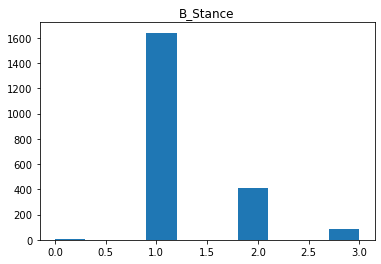

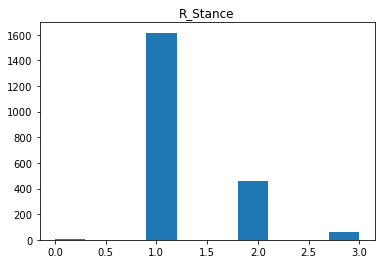

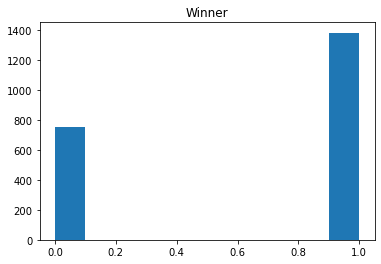

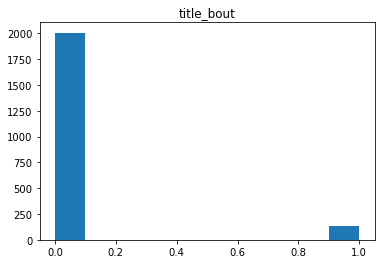

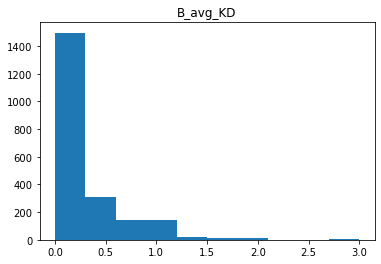

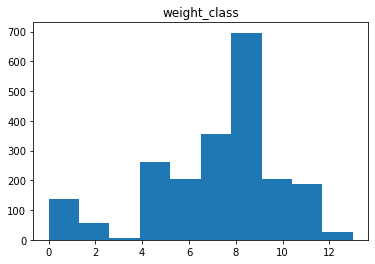

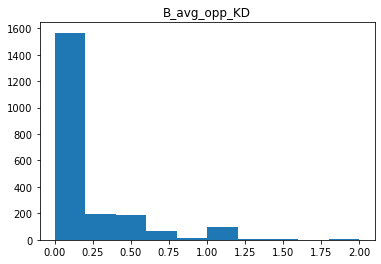

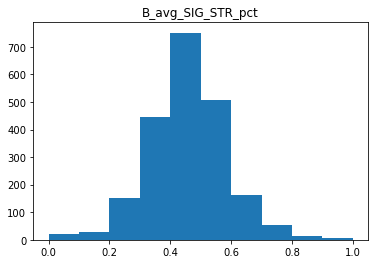

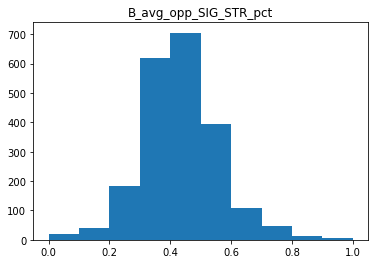

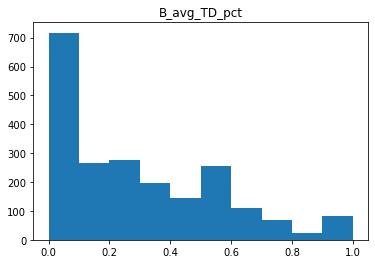

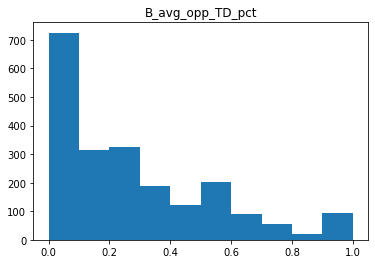

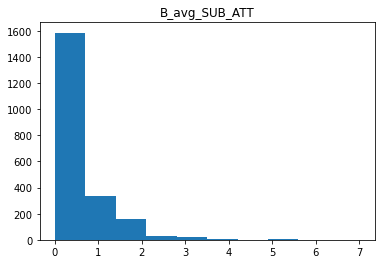

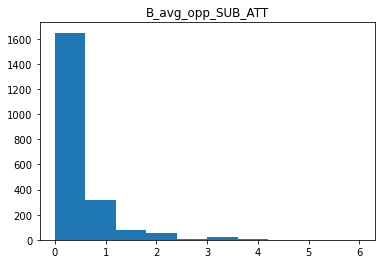

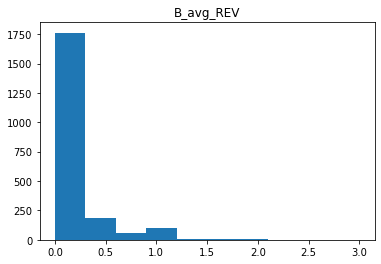

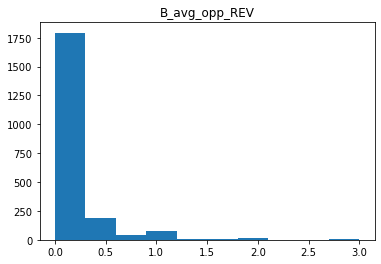

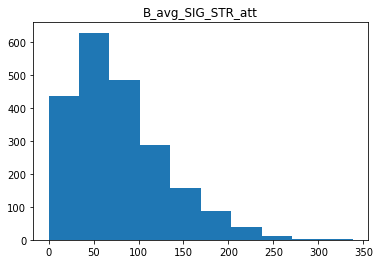

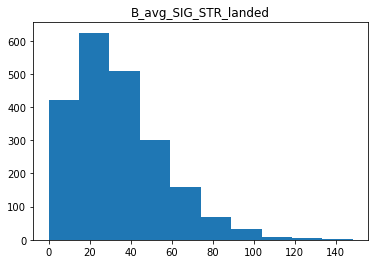

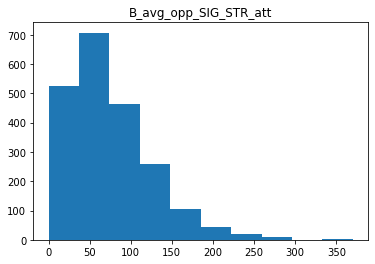

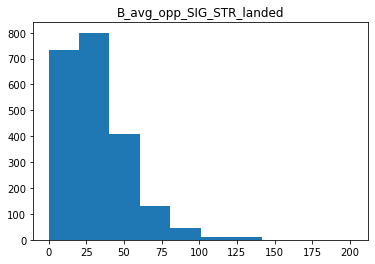

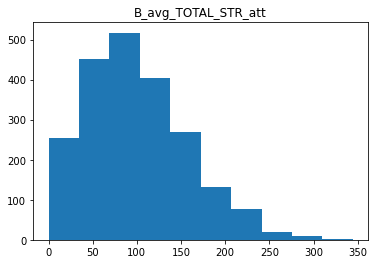

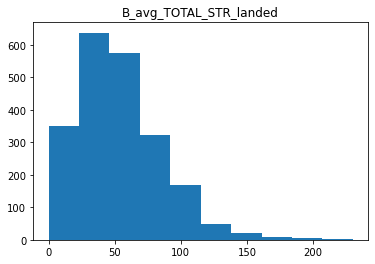

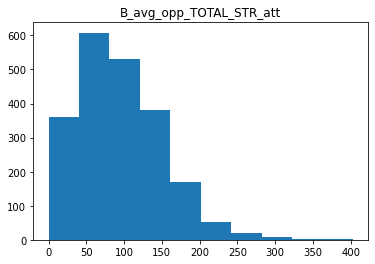

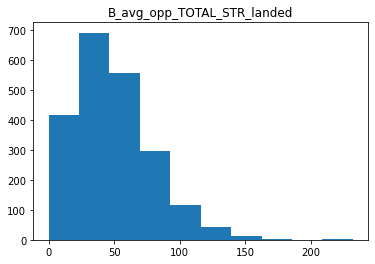

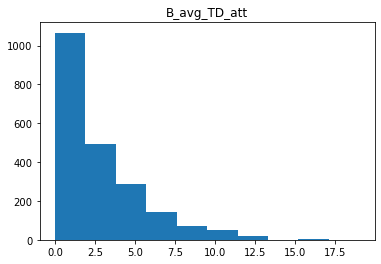

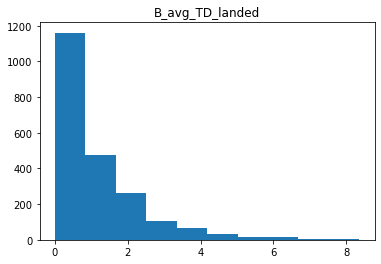

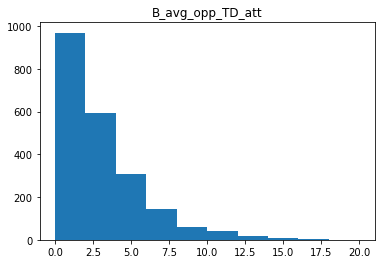

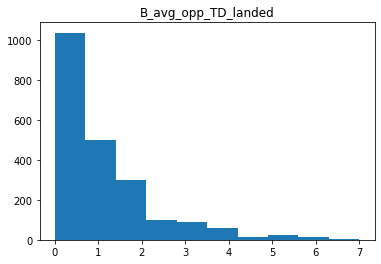

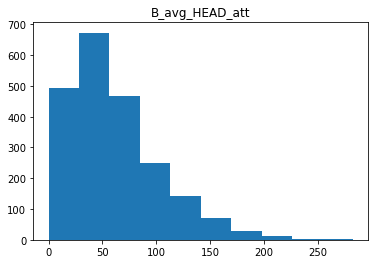

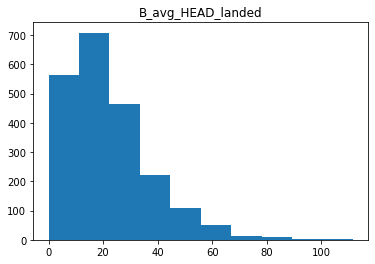

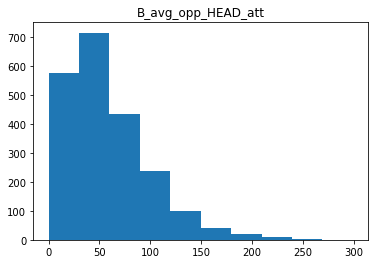

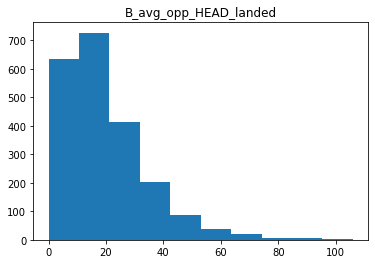

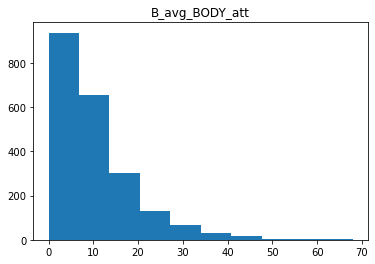

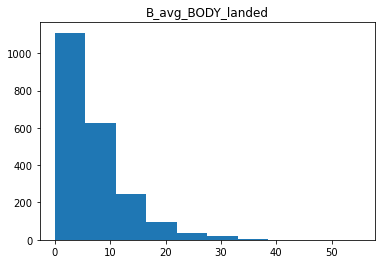

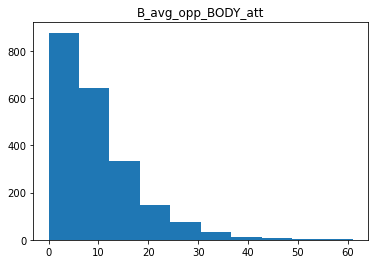

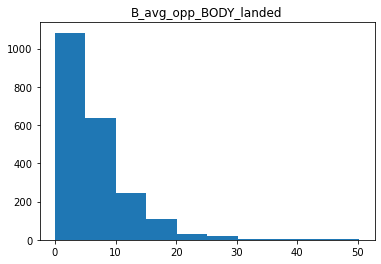

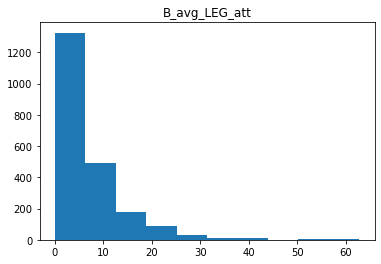

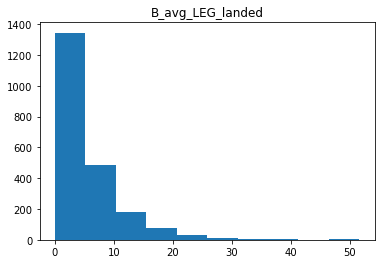

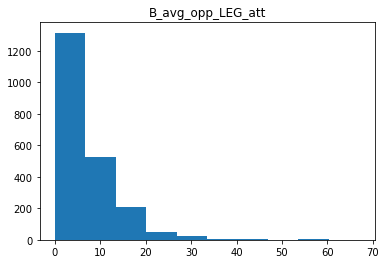

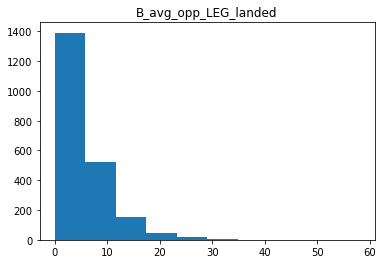

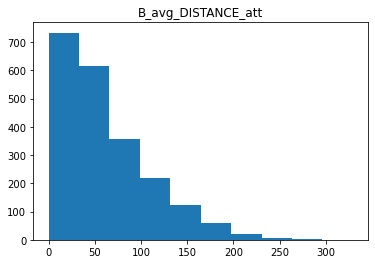

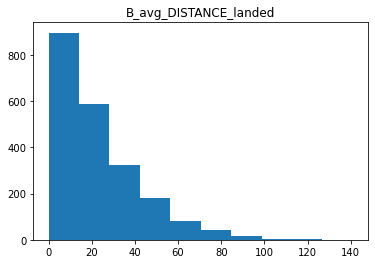

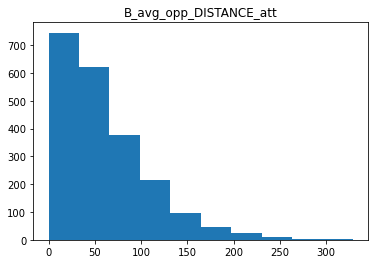

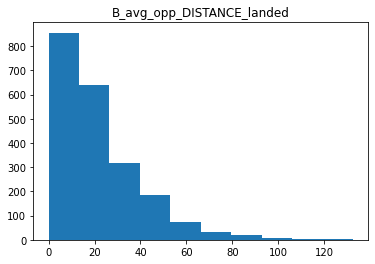

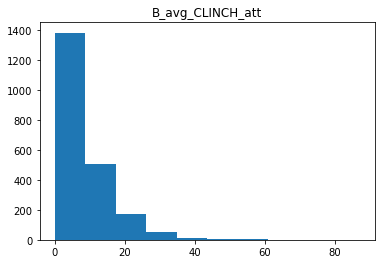

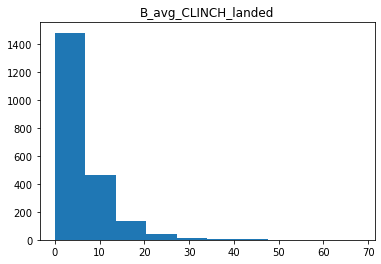

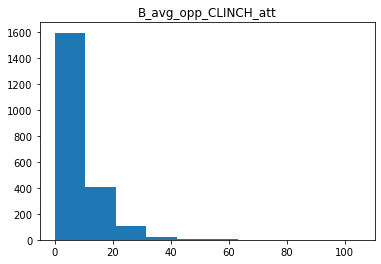

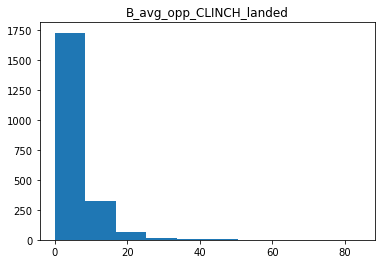

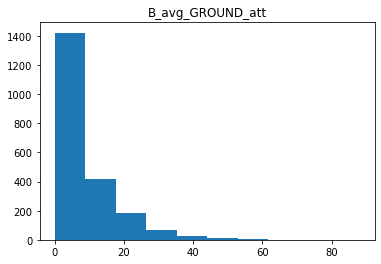

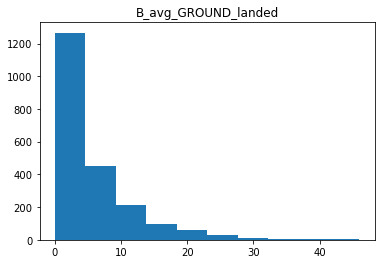

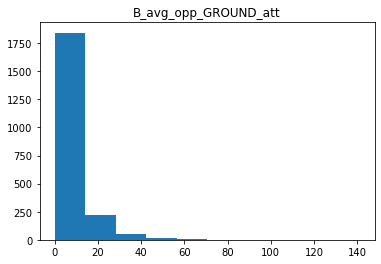

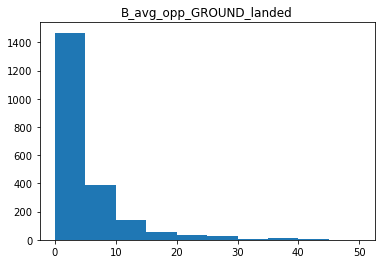

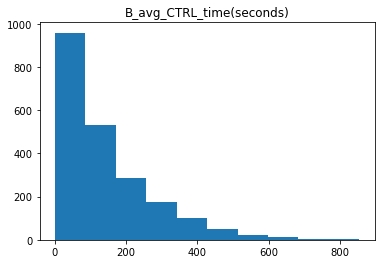

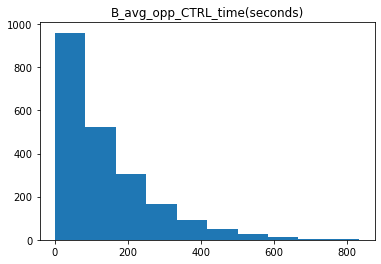

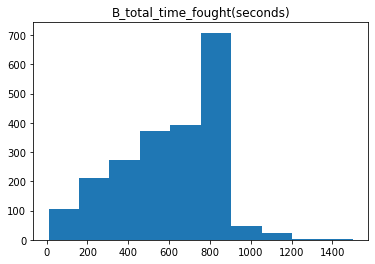

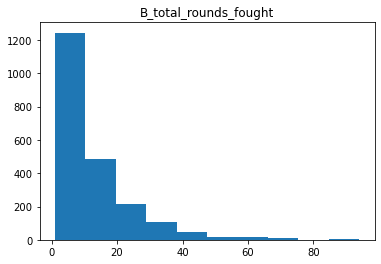

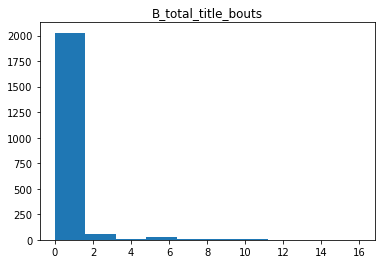

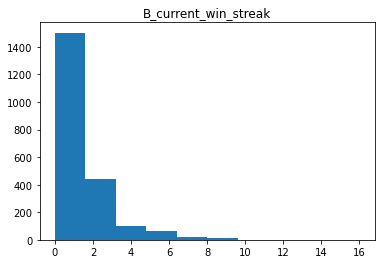

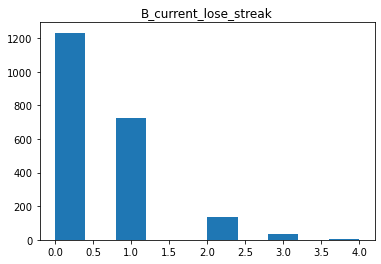

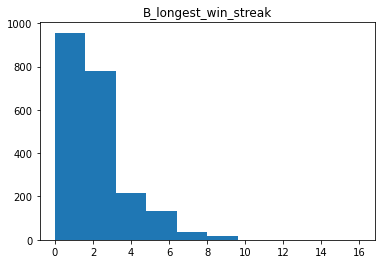

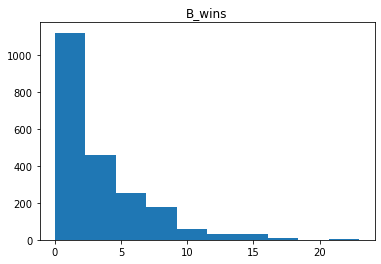

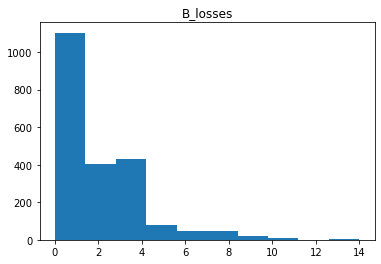

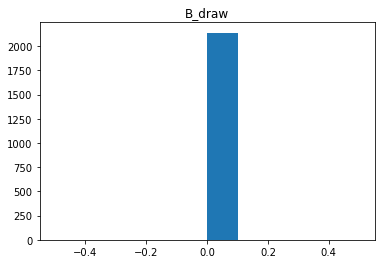

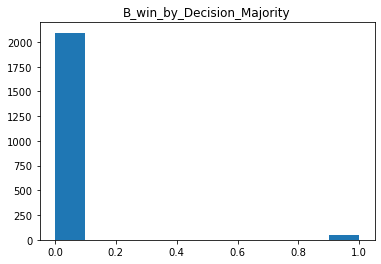

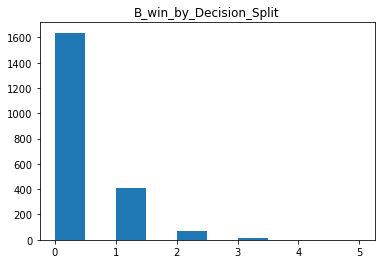

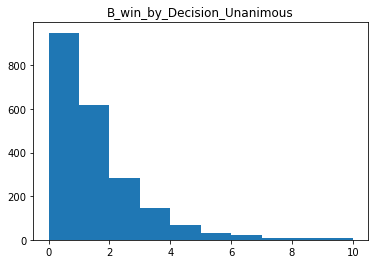

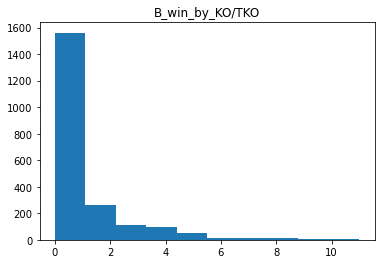

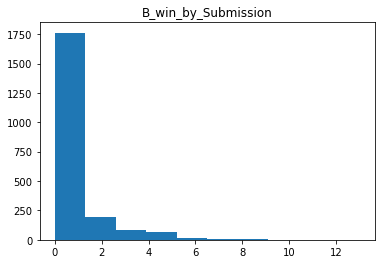

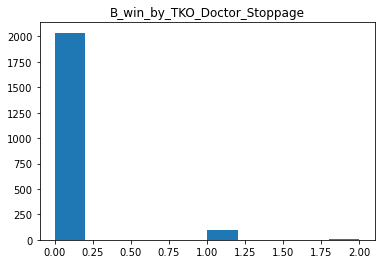

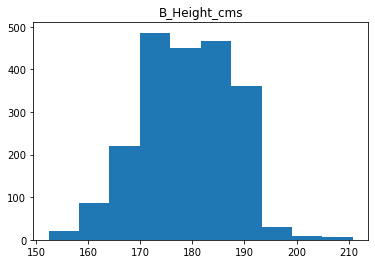

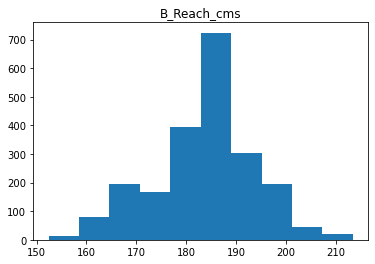

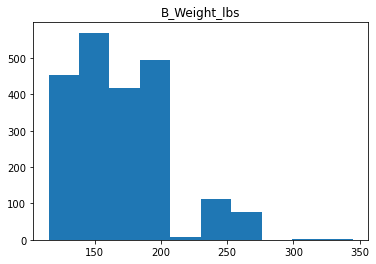

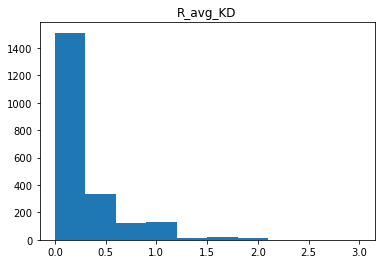

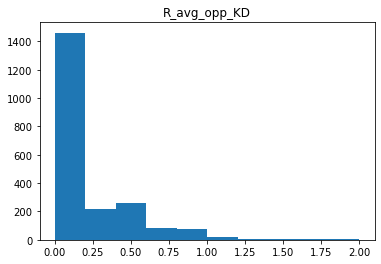

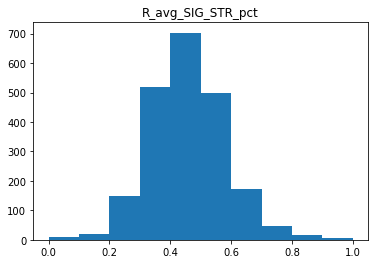

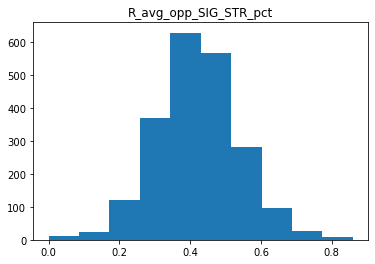

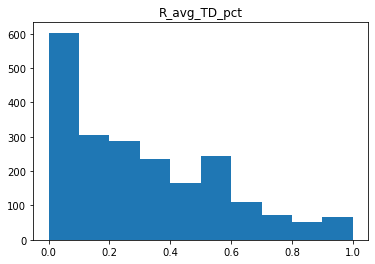

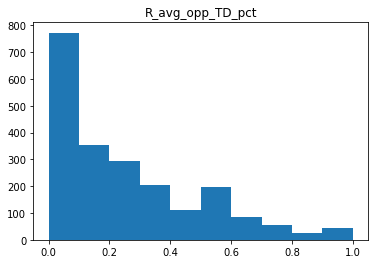

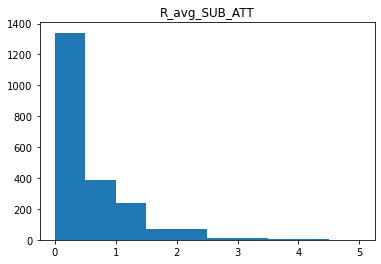

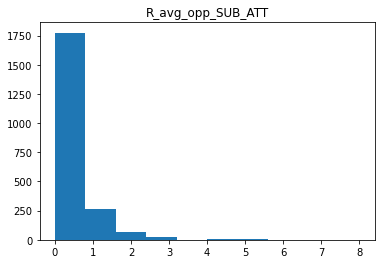

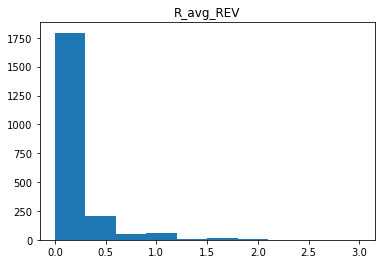

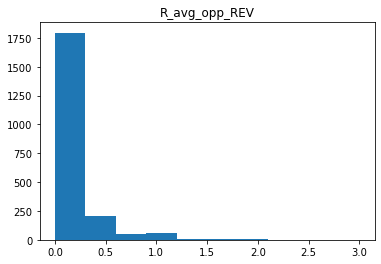

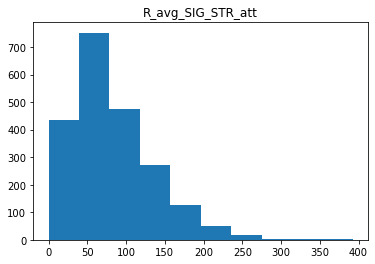

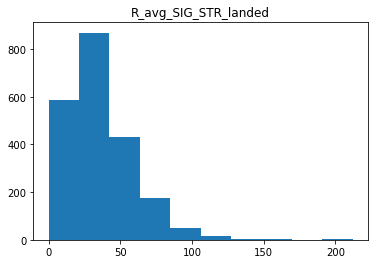

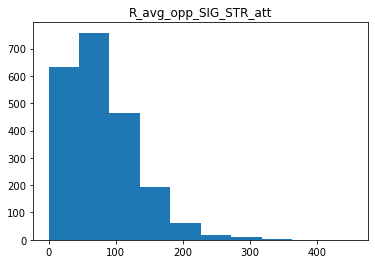

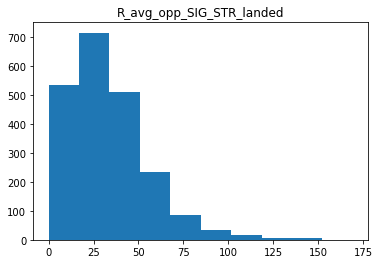

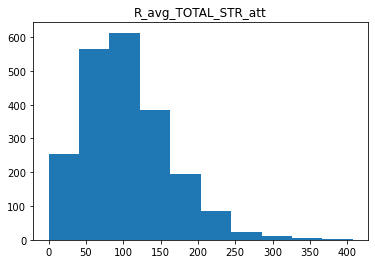

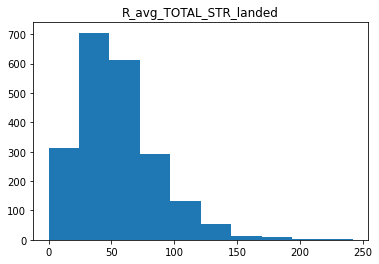

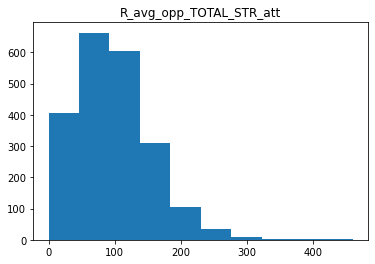

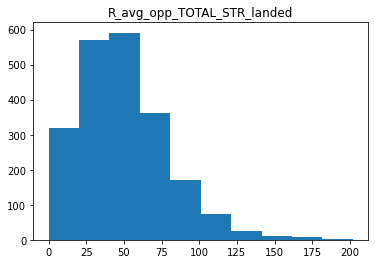

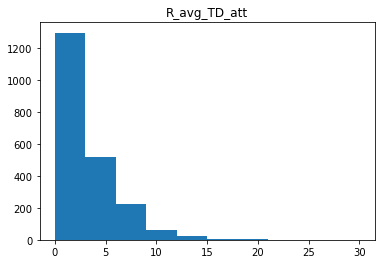

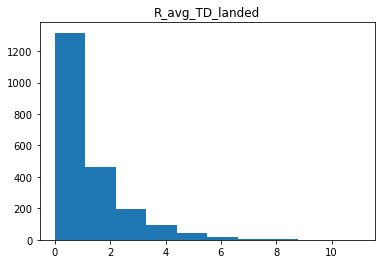

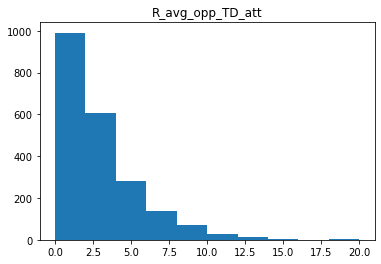

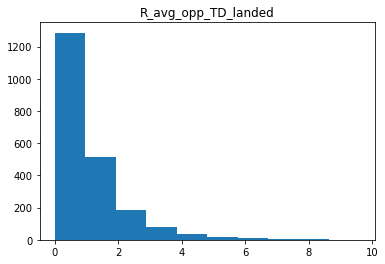

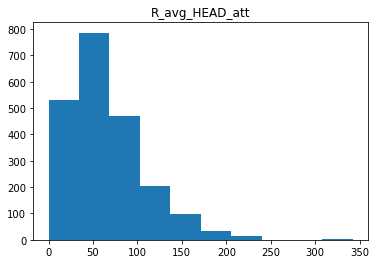

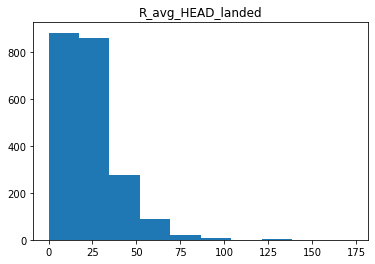

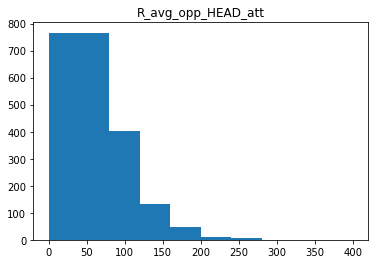

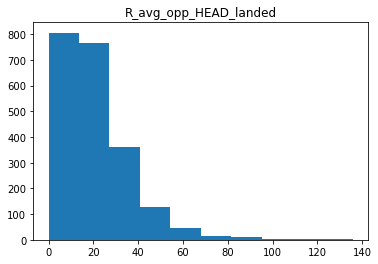

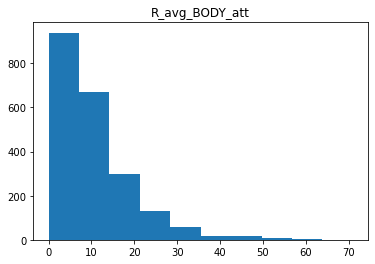

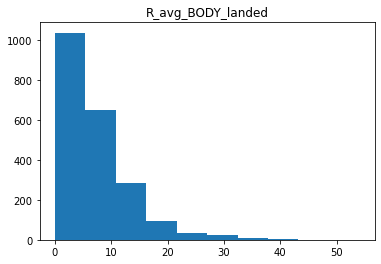

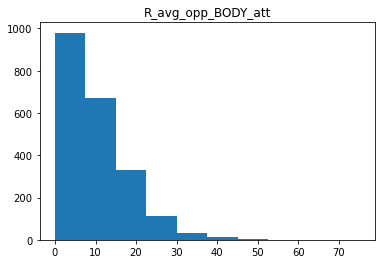

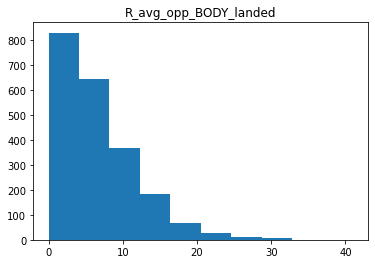

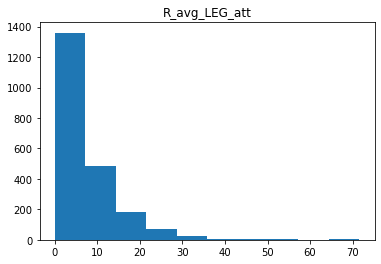

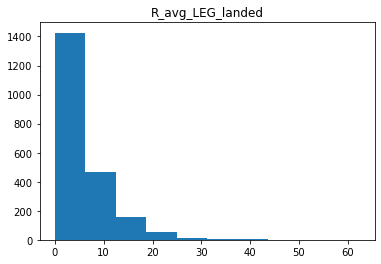

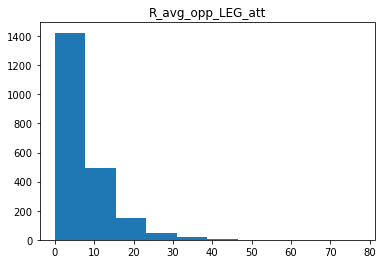

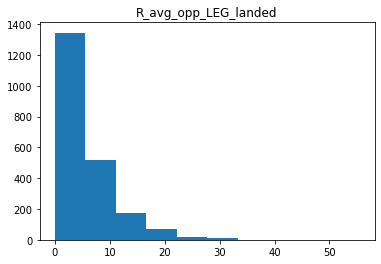

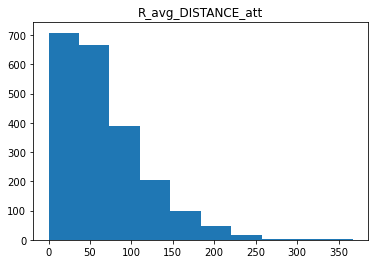

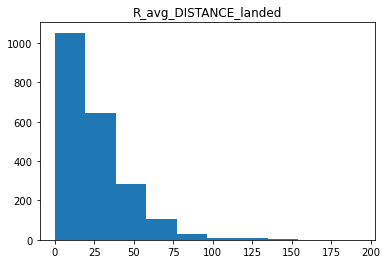

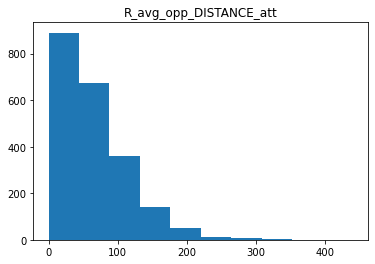

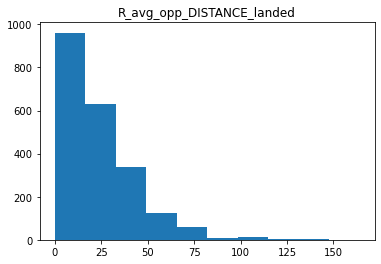

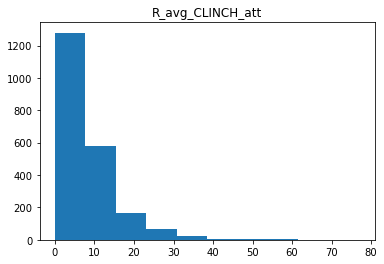

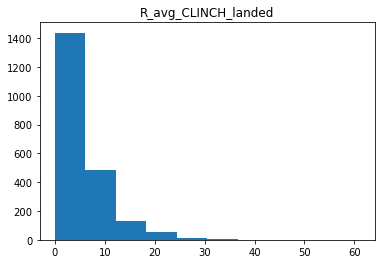

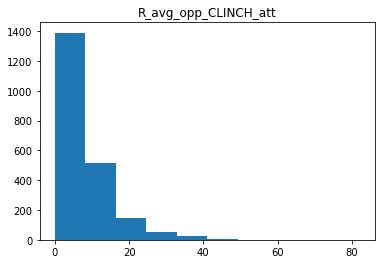

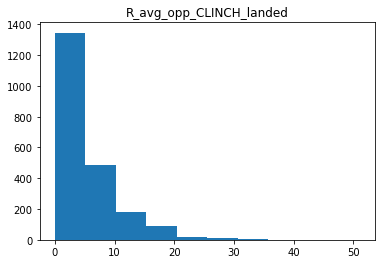

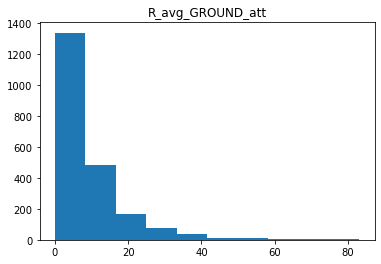

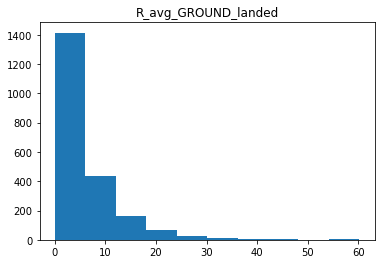

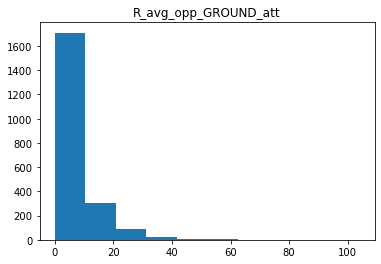

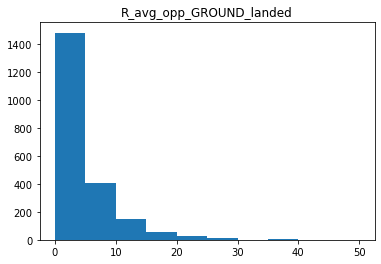

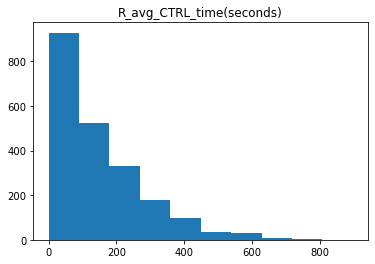

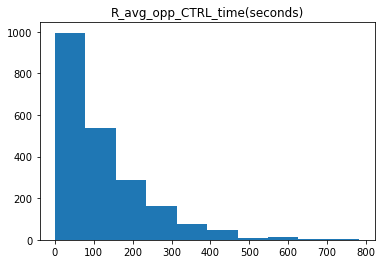

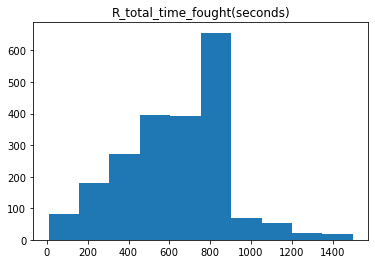

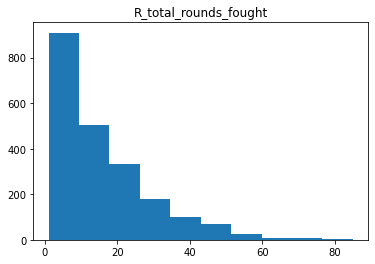

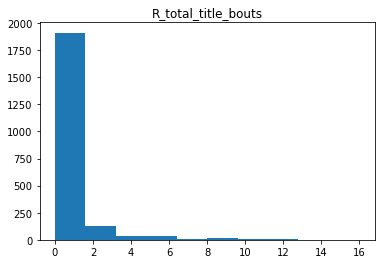

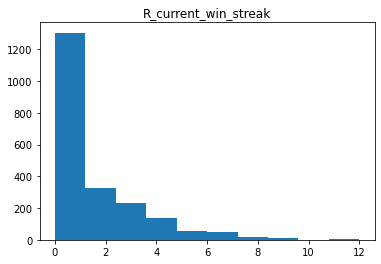

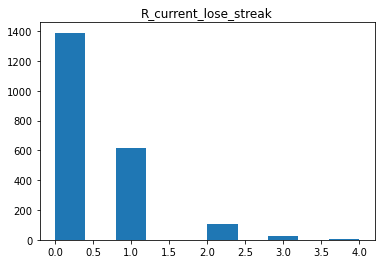

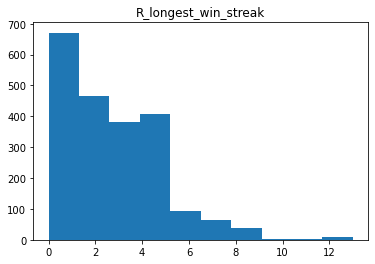

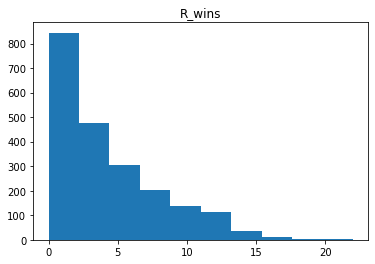

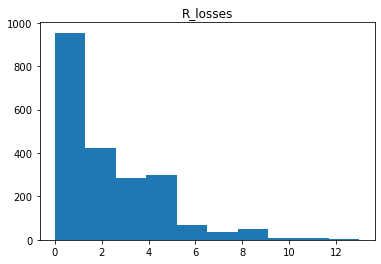

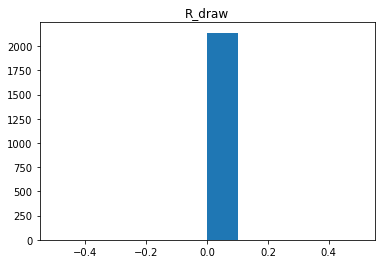

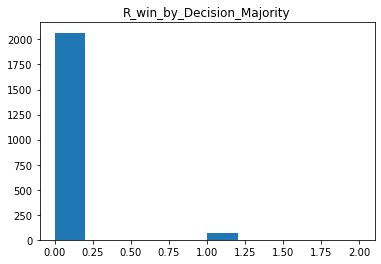

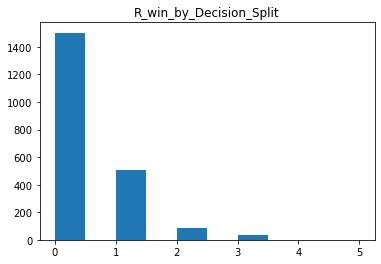

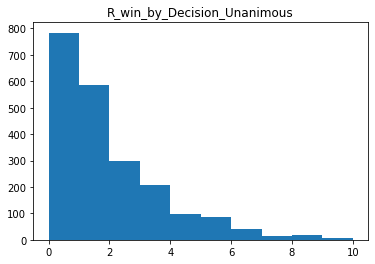

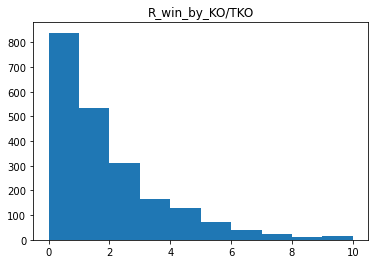

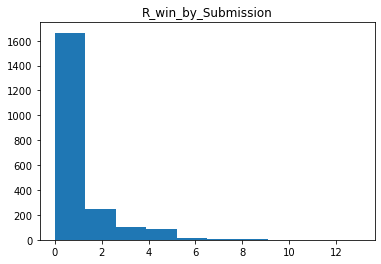

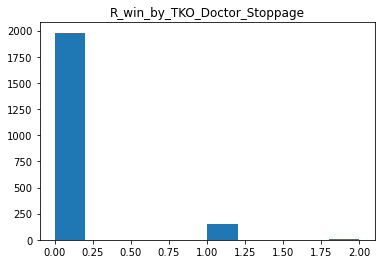

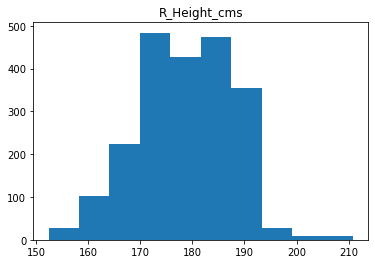

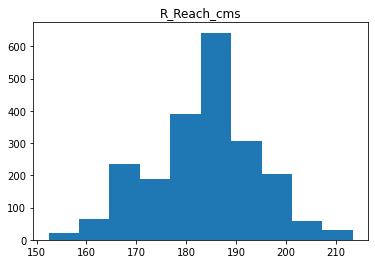

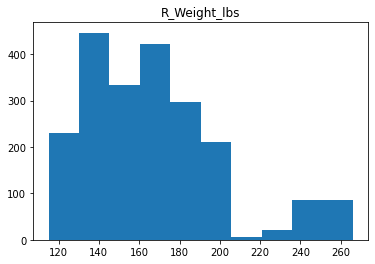

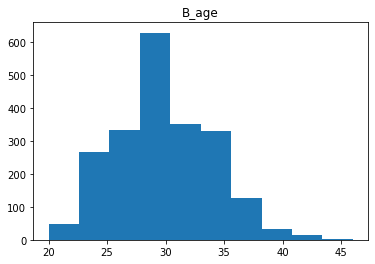

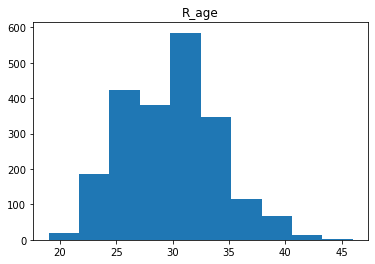

In [31]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [32]:
def explore_univariate(df, variable):
    '''
    explore_univariate will take in a dataframe, and one feature or variable. It graphs a box plot and a distribution 
    of the single variable.
    '''
    #set figure size, font for axis ticks, and turns off gridlines.
    plt.figure(figsize=(30,10))
    sns.set(font_scale = 2)
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    # boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=variable, data=df)
    plt.xlabel('')
    plt.title('Box Plot', fontsize=30)
    
    # distribution
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=variable, element='step', kde=True, color='blue')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Distribution', fontsize=30)
    
    #title
    plt.suptitle(f'{variable}', fontsize = 45)
    plt.tight_layout()
    plt.show()


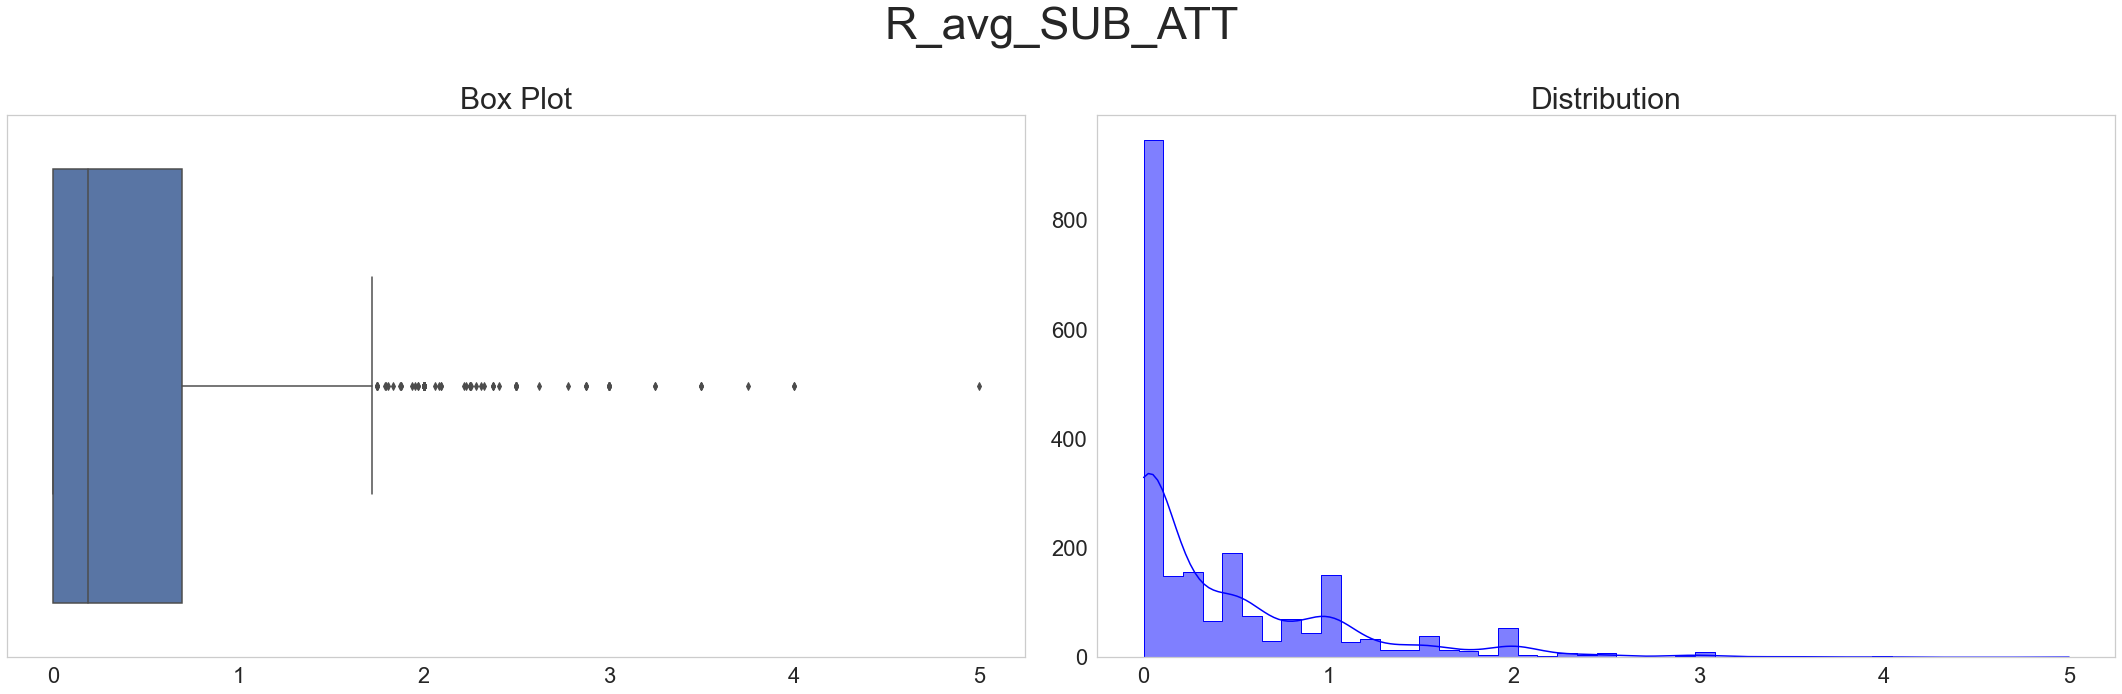

Summary Statistics for R_avg_SUB_ATT
count    2138.000000
mean        0.450484
std         0.621308
min         0.000000
25%         0.000000
50%         0.187500
75%         0.692871
max         5.000000
Name: R_avg_SUB_ATT, dtype: float64


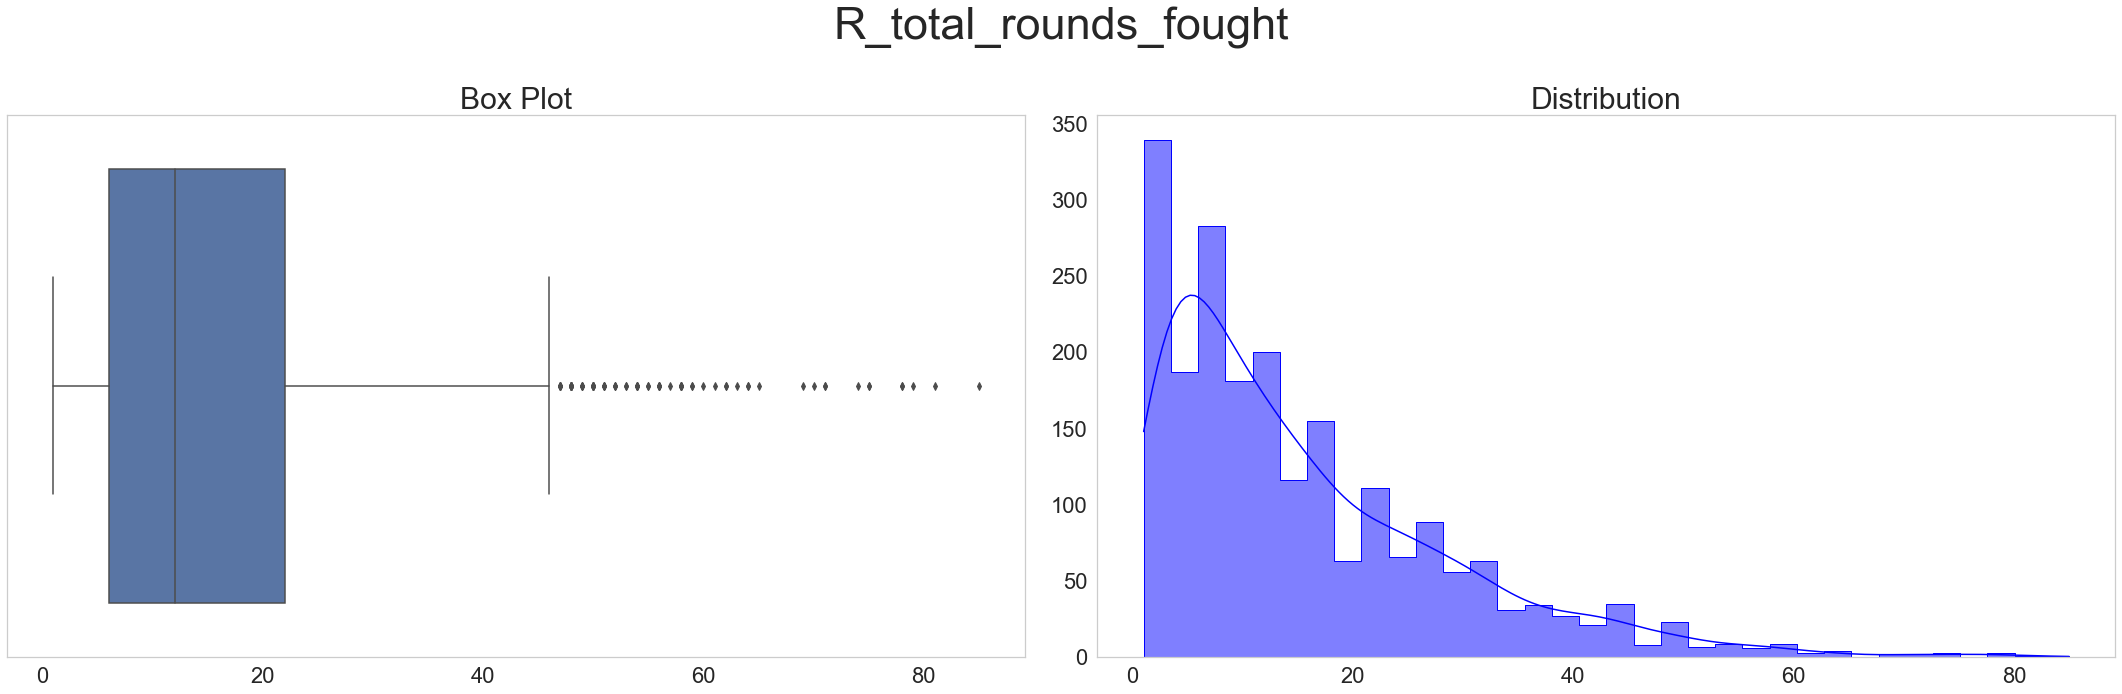

Summary Statistics for R_total_rounds_fought
count    2138.000000
mean       15.724509
std        13.527572
min         1.000000
25%         6.000000
50%        12.000000
75%        22.000000
max        85.000000
Name: R_total_rounds_fought, dtype: float64


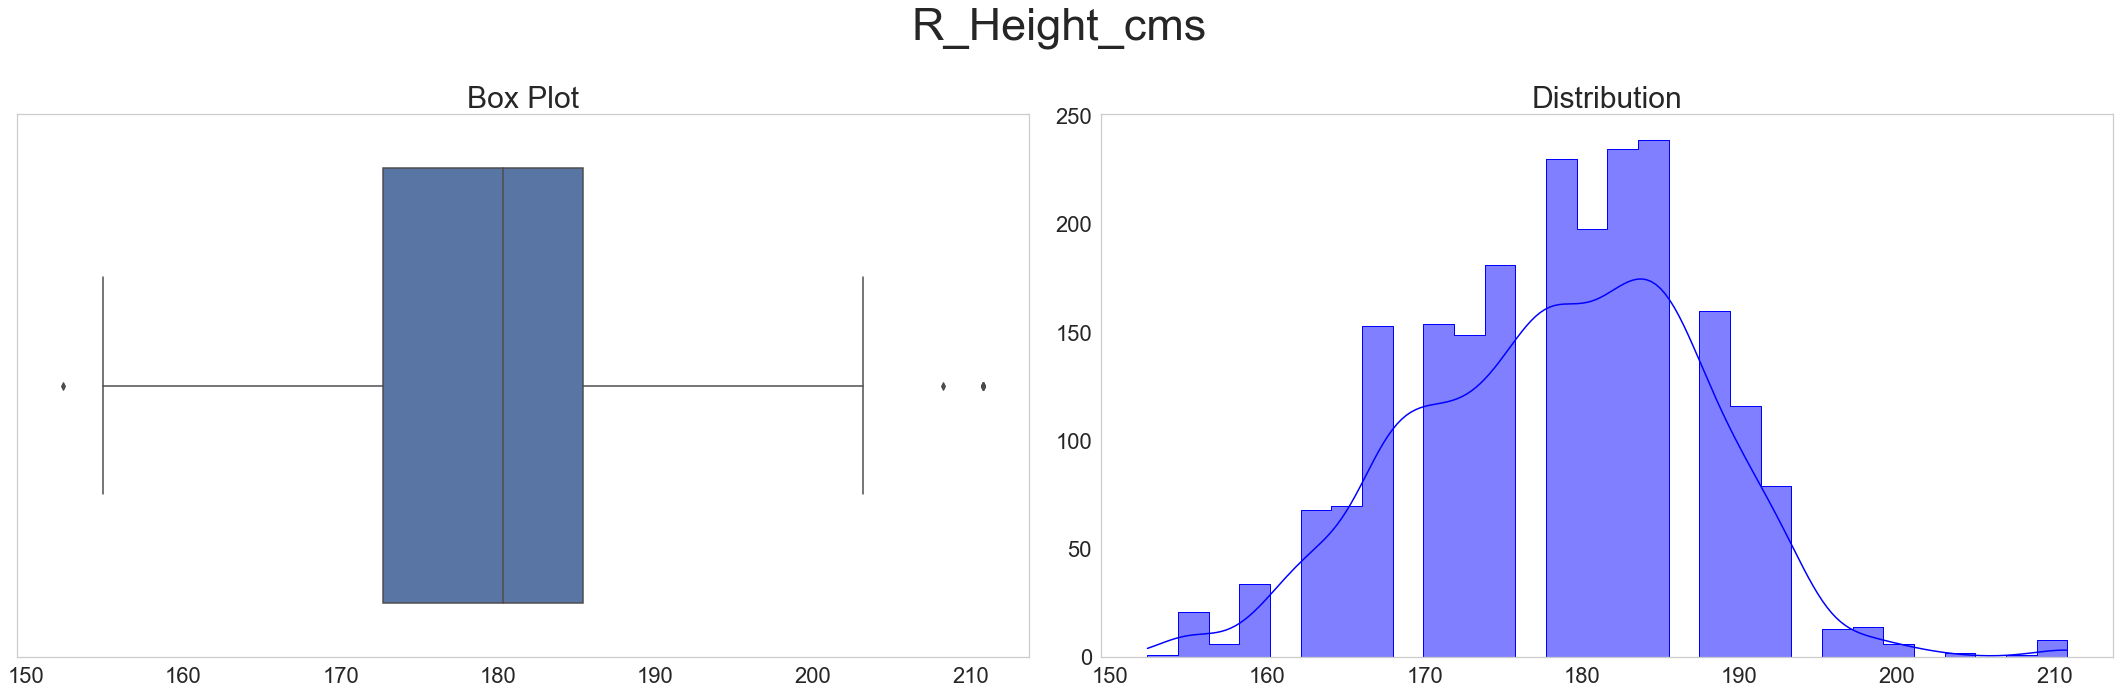

Summary Statistics for R_Height_cms
count    2138.000000
mean      178.603106
std         9.153692
min       152.400000
25%       172.720000
50%       180.340000
75%       185.420000
max       210.820000
Name: R_Height_cms, dtype: float64


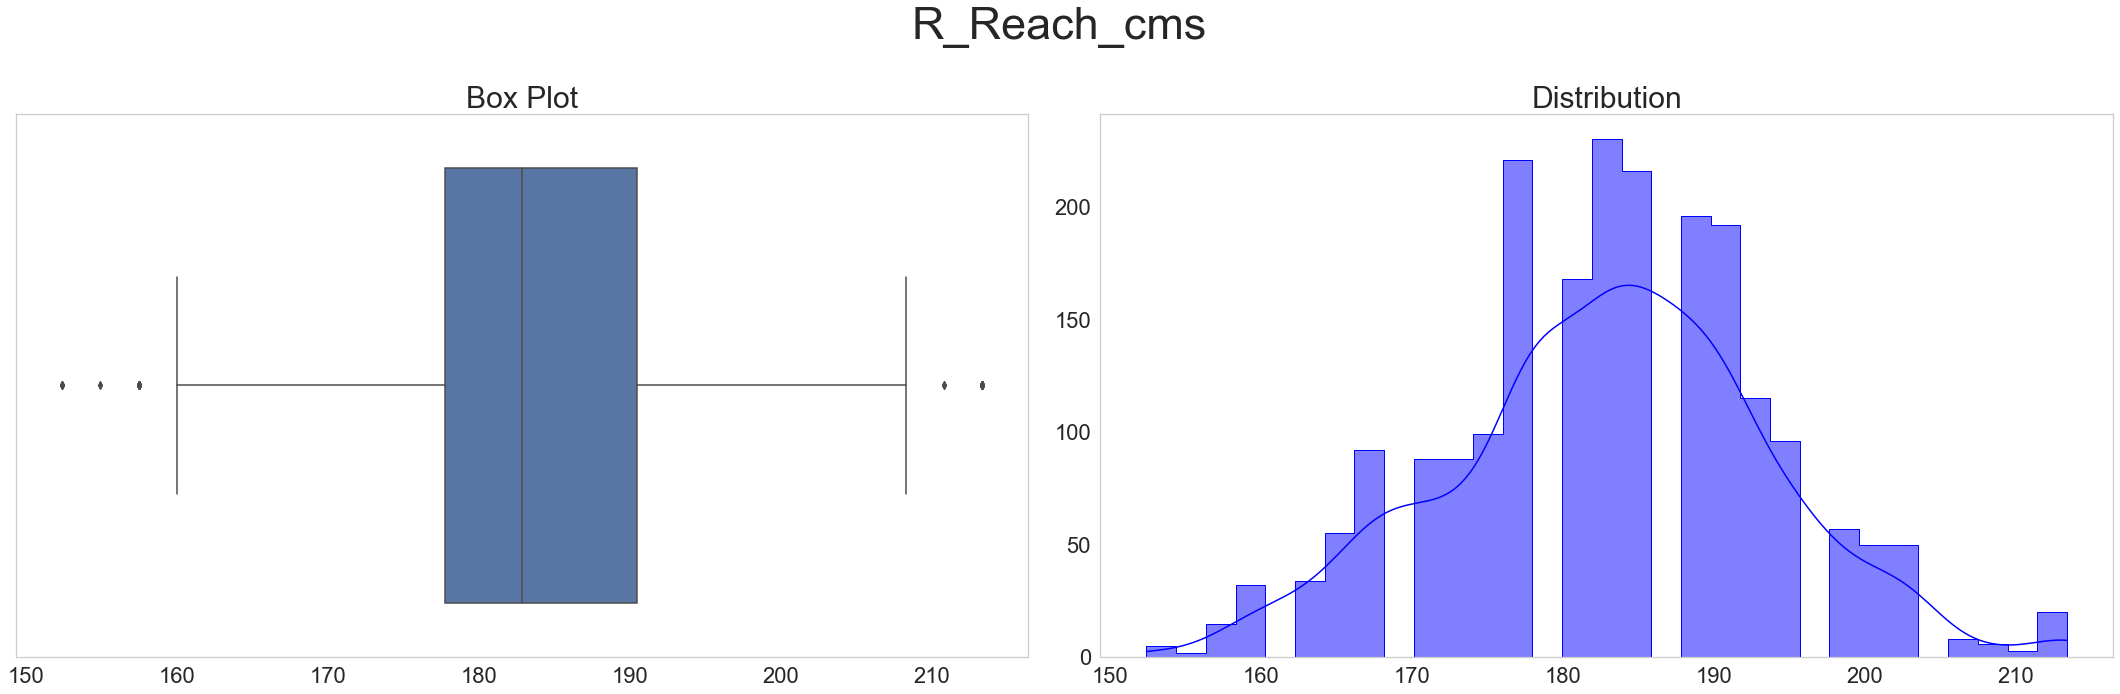

Summary Statistics for R_Reach_cms
count    2138.000000
mean      183.109289
std        10.701186
min       152.400000
25%       177.800000
50%       182.880000
75%       190.500000
max       213.360000
Name: R_Reach_cms, dtype: float64


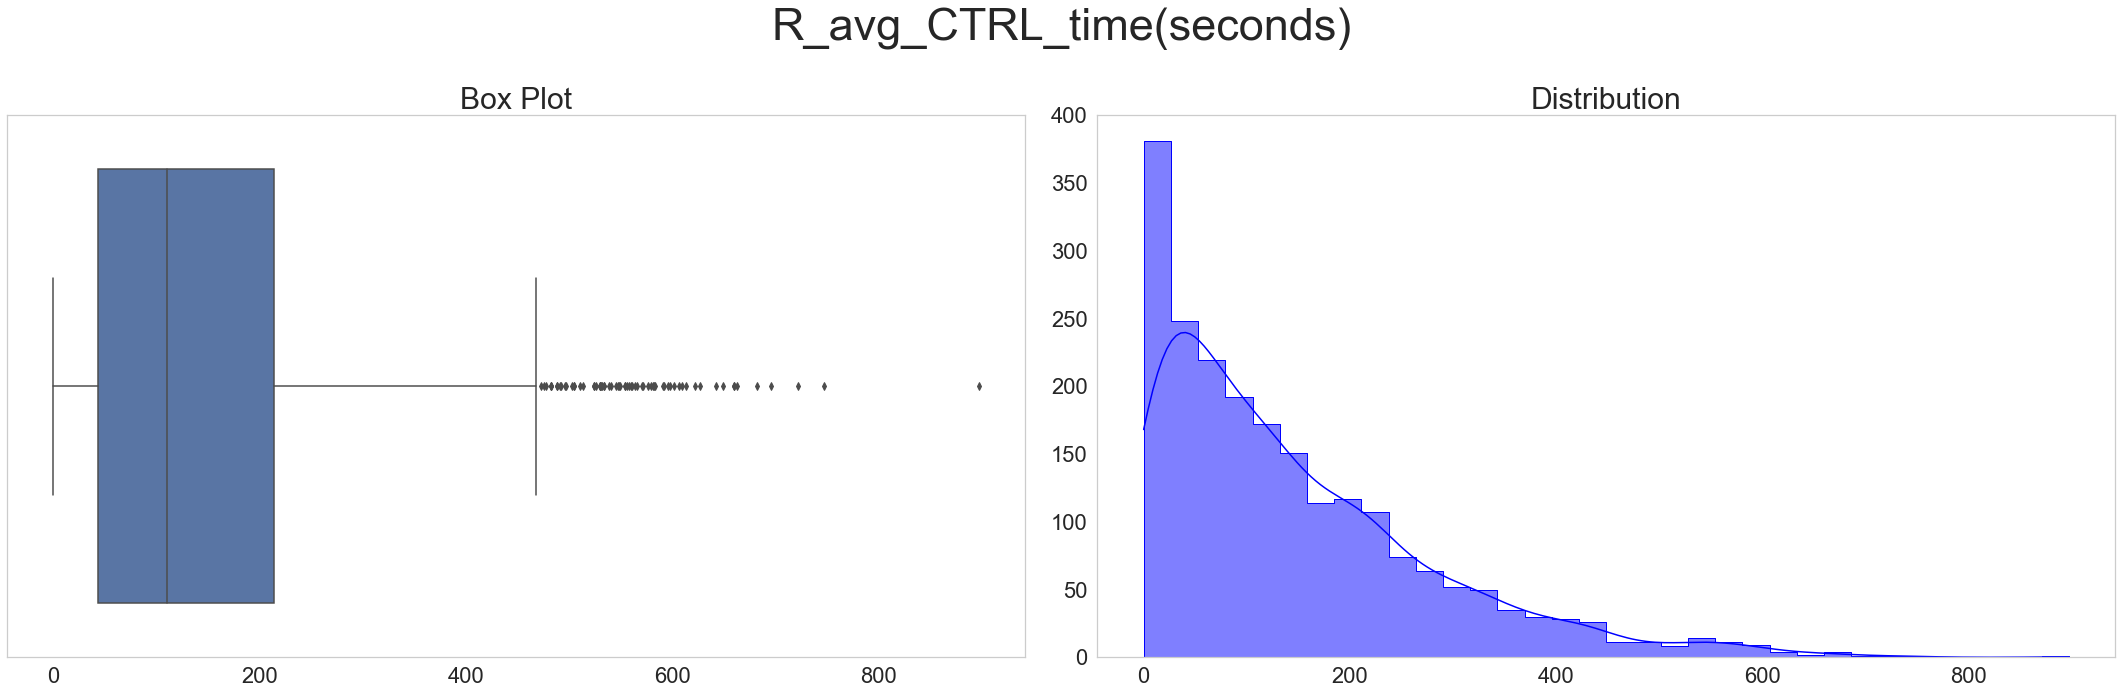

Summary Statistics for R_avg_CTRL_time(seconds)
count    2138.000000
mean      146.434097
std       134.287190
min         0.000000
25%        43.000000
50%       109.636719
75%       213.437500
max       897.359375
Name: R_avg_CTRL_time(seconds), dtype: float64


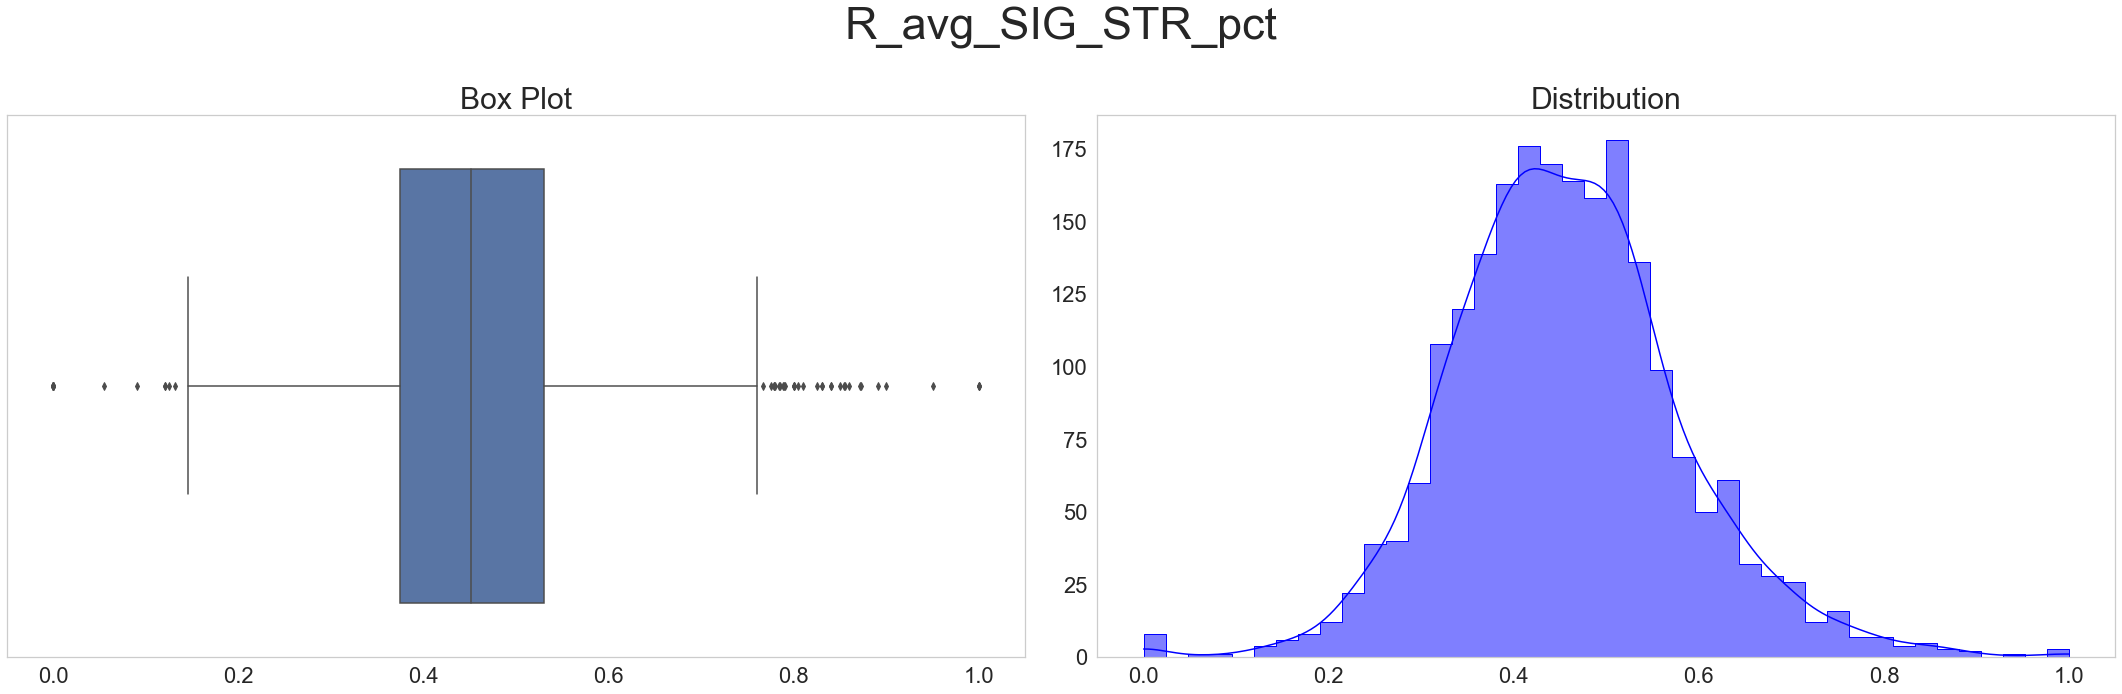

Summary Statistics for R_avg_SIG_STR_pct
count    2138.000000
mean        0.456273
std         0.125279
min         0.000000
25%         0.374387
50%         0.450948
75%         0.529785
max         1.000000
Name: R_avg_SIG_STR_pct, dtype: float64


In [33]:
univariate_study = ['R_avg_SUB_ATT','R_total_rounds_fought','R_Height_cms','R_Reach_cms','R_avg_CTRL_time(seconds)','R_avg_SIG_STR_pct']

for i in univariate_study:
    explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

## Take aways

- Stance - majority are orthodox
- Majority of classes are Featherweight and lightweight
- Sig str pct is normally distributed
- avg takedown is right skewed
- avg sig str att is right skewed
- majority of wins are determined by majority decision
- more wins by submission then tko
- height and reach are almost normally distributed


# Bivariate Exploration

Winner and submission attempts


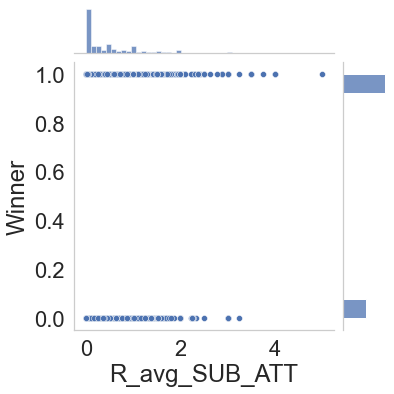

In [34]:
#Winner and submission attempts
print('Winner and submission attempts')
sns.jointplot(x='R_avg_SUB_ATT', y='Winner', data=train)
plt.xlabel('R_avg_SUB_ATT')
plt.ylabel('Winner')
plt.show()

In [35]:
null_hypothesis = "no difference in a winner with more then one submission attempt vs no submission attempts"
alternative_hypothesis = "there is a difference in a winner with more then one submission attempt vs no submission attempts"
a = 0.05 #a for alpha 

subattempt=train[train.R_avg_SUB_ATT>1].Winner
no_subattempt = train[train.R_avg_SUB_ATT<1].Winner
t, p = stats.ttest_ind(subattempt, no_subattempt)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.019454658099556564
Reject null hypothesis that: no difference in a winner with more then one submission attempt vs no submission attempts
There is evidence to suggest: there is a difference in a winner with more then one submission attempt vs no submission attempts


Winner and Total Rounds Fought


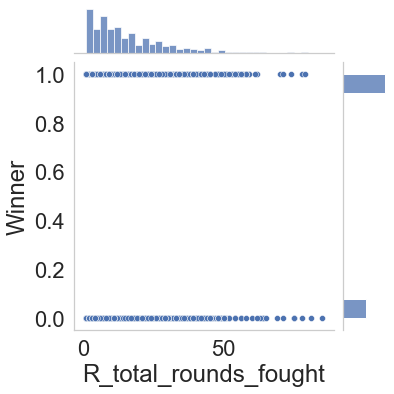

In [36]:
#Winner and total rounds fought
print('Winner and Total Rounds Fought')
sns.jointplot(x='R_total_rounds_fought', y='Winner', data=train)
plt.xlabel('R_total_rounds_fought')
plt.ylabel('Winner')
plt.show()

In [37]:
null_hypothesis = "no difference in a winner with more then 16 rounds fought vs less then 16 rounds fought"
alternative_hypothesis = "there is a difference in a winner with more then 16 rounds fought vs less then 16 rounds fought"
a = 0.05 #a for alpha 

morerds=train[train.R_total_rounds_fought>16].Winner
lessrds = train[train.R_total_rounds_fought<16].Winner
t, p = stats.ttest_ind(morerds, lessrds)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.00013931464146878204
Reject null hypothesis that: no difference in a winner with more then 16 rounds fought vs less then 16 rounds fought
There is evidence to suggest: there is a difference in a winner with more then 16 rounds fought vs less then 16 rounds fought


Winner and Reach


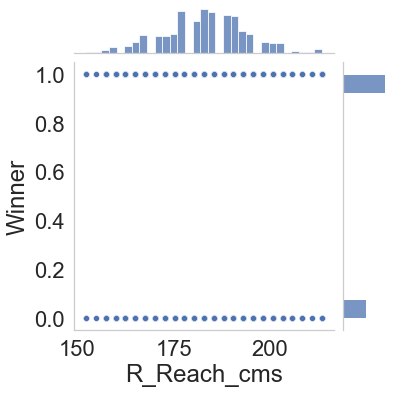

In [38]:
#Winner and reach
print('Winner and Reach')
sns.jointplot(x='R_Reach_cms', y='Winner', data=train)
plt.xlabel('R_Reach_cms')
plt.ylabel('Winner')
plt.show()

In [39]:
null_hypothesis = "no difference in a winner with a reach longer then 183 cm vs someone who has less reach"
alternative_hypothesis = "there is a difference in a winner with a reach longer then 183 cm vs someone who has less reach"
a = 0.05 #a for alpha 

more_reach=train[train.R_Reach_cms>183].Winner
less_reach = train[train.R_Reach_cms<183].Winner
t, p = stats.ttest_ind(more_reach, less_reach)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

0.5637656368950537
Fail to reject null hypothesis that: no difference in a winner with a reach longer then 183 cm vs someone who has less reach There is not sufficient evidence to reject it.


Winner and Significant Strikes


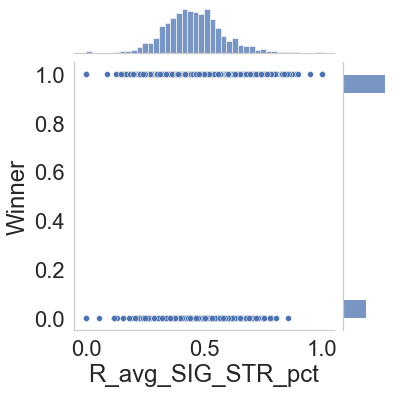

In [40]:
#Winner and significant strikes
print('Winner and Significant Strikes')
sns.jointplot(x='R_avg_SIG_STR_pct', y='Winner', data=train)
plt.xlabel('R_avg_SIG_STR_pct')
plt.ylabel('Winner')
plt.show()

In [41]:
null_hypothesis = "no difference in a winner with a signifcant strike percentage over 50% vs less then 50%"
alternative_hypothesis = "there is a difference in a winner with a signifcant strike percentage over 50% vs less then 50%"
a = 0.05 #a for alpha 

more_stri=train[train.R_avg_SIG_STR_pct>.50].Winner
less_stri = train[train.R_avg_SIG_STR_pct<.50].Winner
t, p = stats.ttest_ind(more_stri, less_stri)
print(p)
if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

9.65027270677872e-05
Reject null hypothesis that: no difference in a winner with a signifcant strike percentage over 50% vs less then 50%
There is evidence to suggest: there is a difference in a winner with a signifcant strike percentage over 50% vs less then 50%


## Multivariate Analysis

In [42]:
cat_vars = ['title_bout','weight_class','R_Stance','R_win_by_Submission']
quant_vars = ['R_Height_cms','R_Reach_cms','R_avg_SIG_STR_pct','R_avg_SUB_ATT']

In [43]:
def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
     

In [44]:
def plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 6), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

In [45]:
def plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

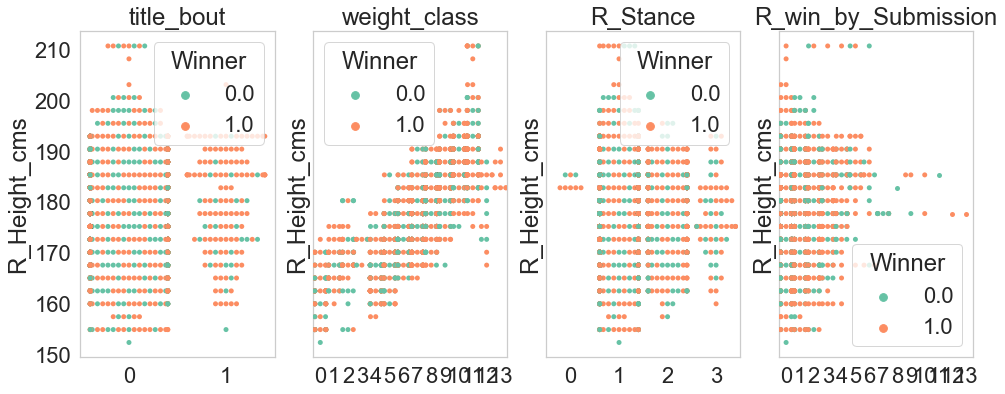

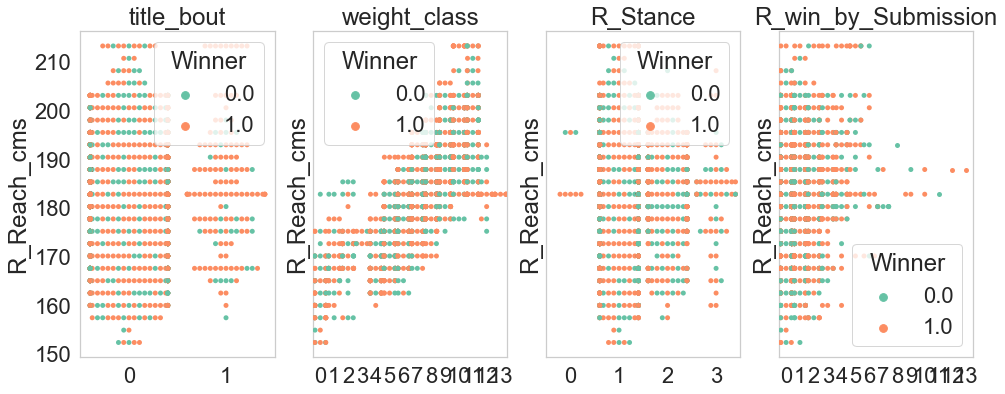

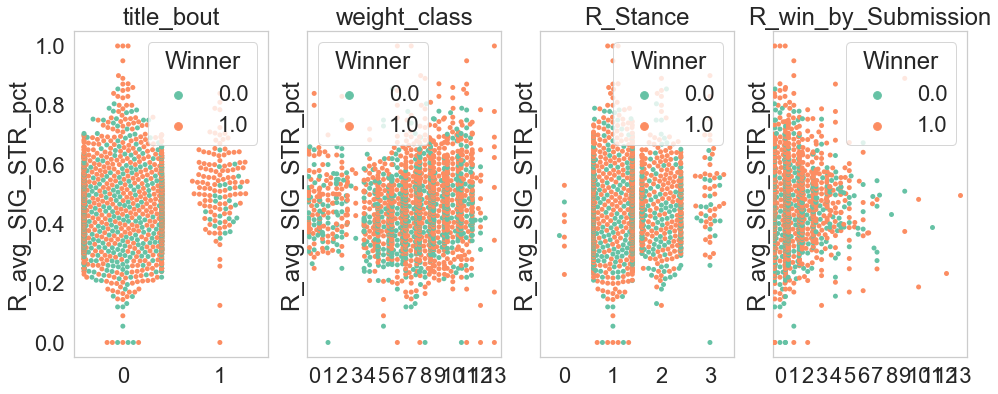

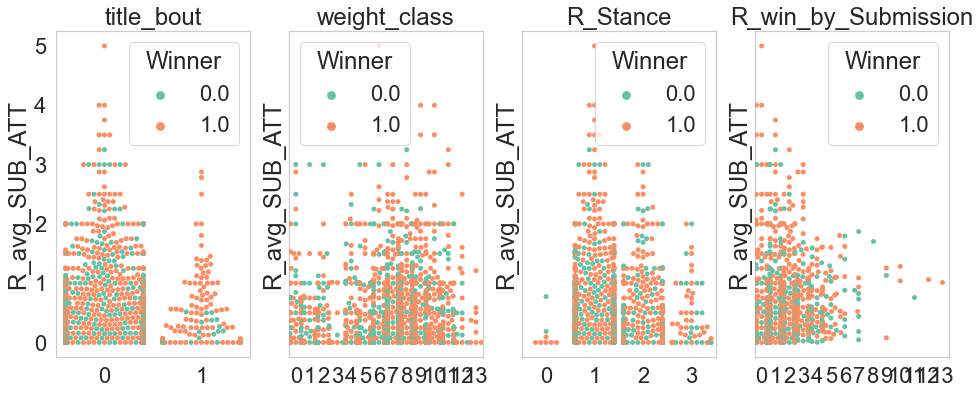

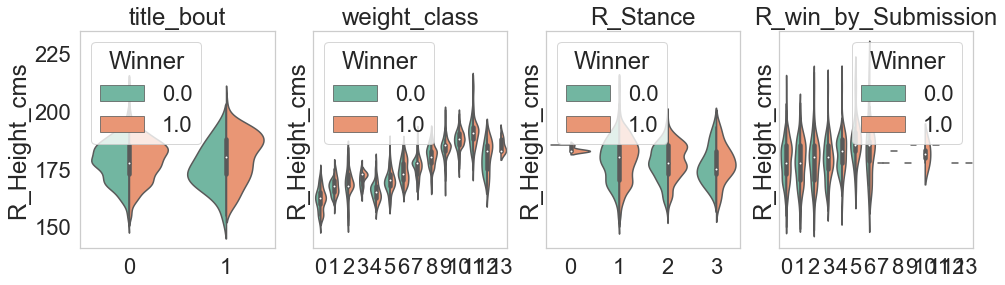

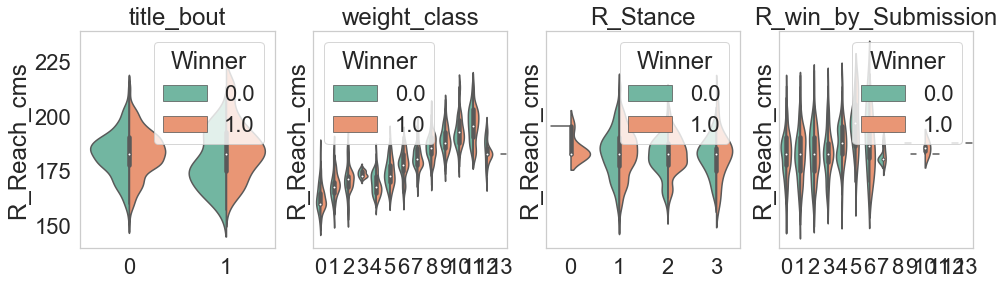

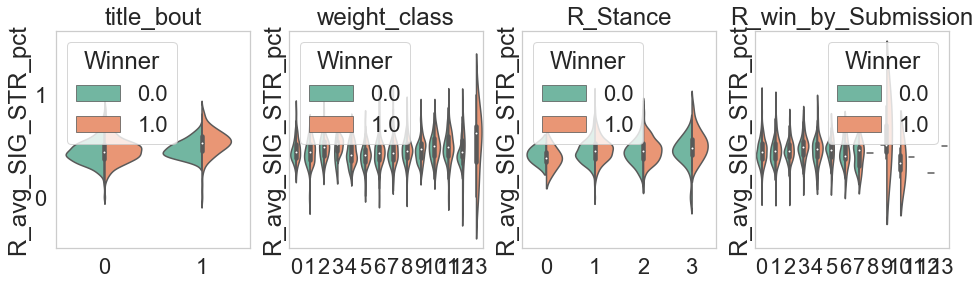

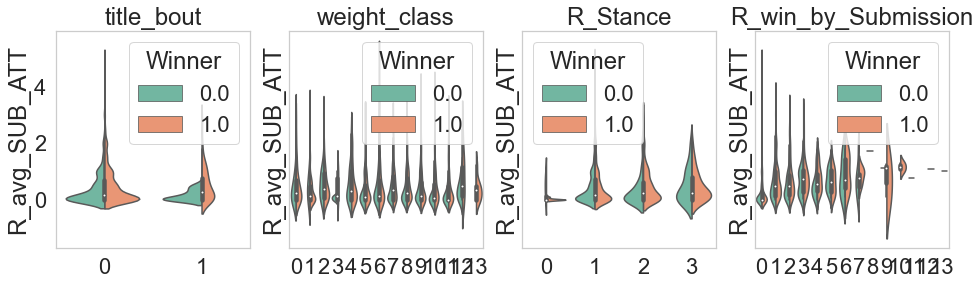

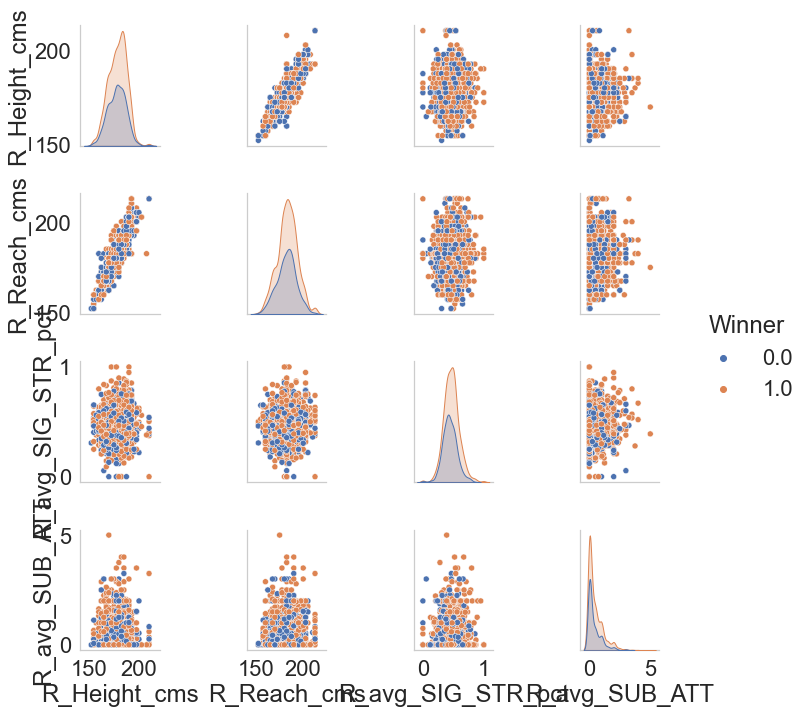

In [46]:
target = 'Winner'
explore_multivariate(train, target, cat_vars, quant_vars)

In [47]:
def get_ufc_heatmap(train):
    '''
    returns a heatmap and correlations of how each feature relates to Winner
    '''
    sns.set()
    plt.figure(figsize=(20,20))
    heatmap = sns.heatmap(train.corr()[['Winner']].sort_values(by='Winner', ascending=False), vmin=-.50, vmax=.50, annot=True)
    heatmap.set_title('Feautures Correlating with Winner')
    
    return heatmap


<AxesSubplot:title={'center':'Feautures Correlating with Winner'}>

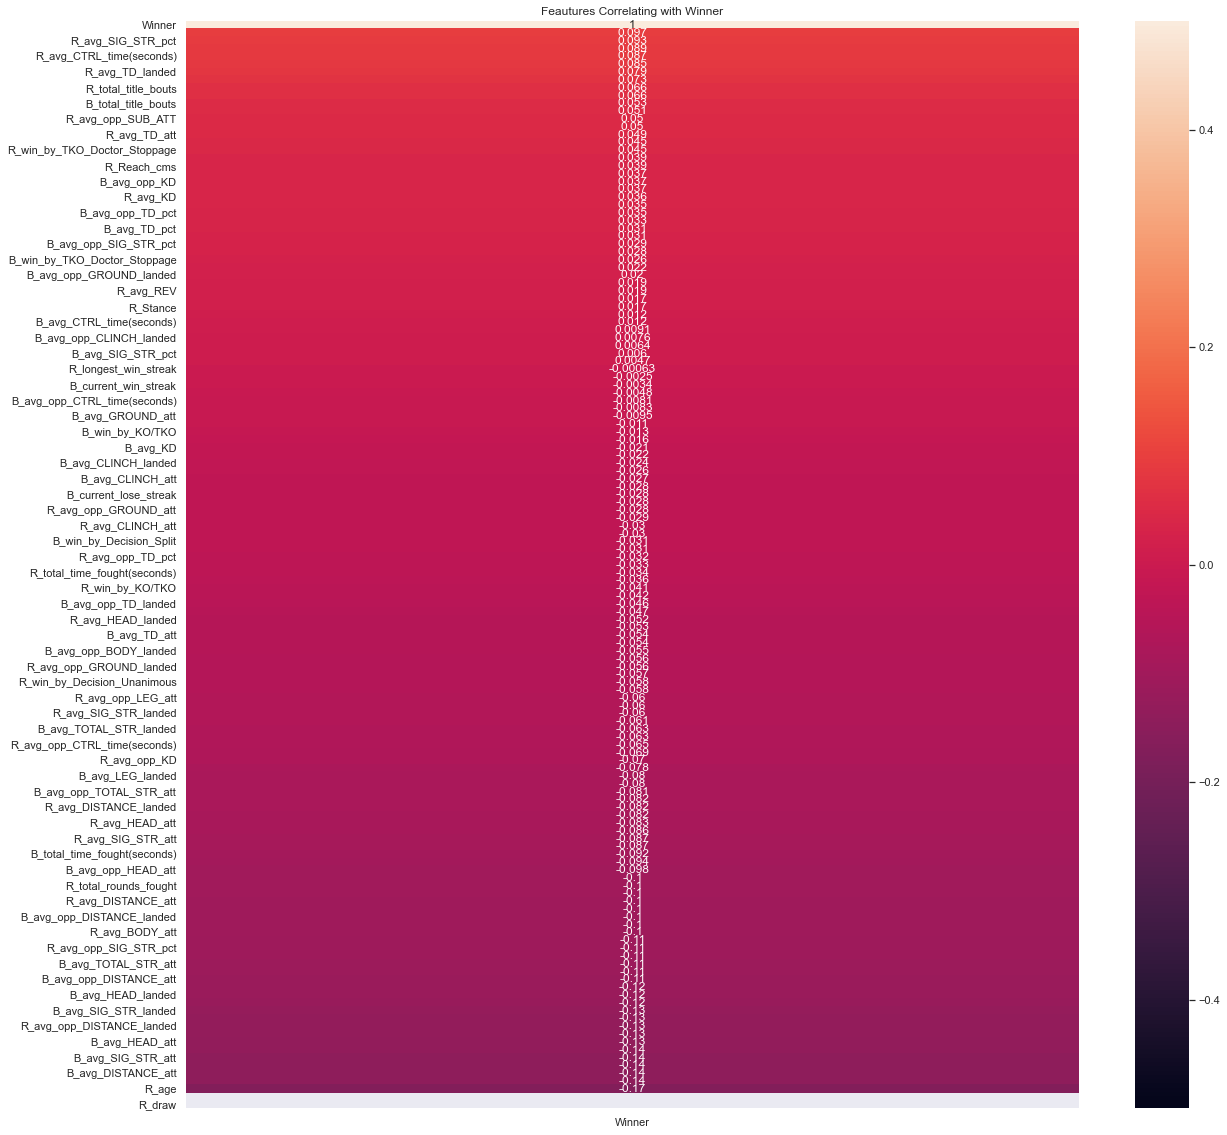

In [48]:
get_ufc_heatmap(train)

### Takeaways 

-More lightweight and welterweights matches


# Model

In [49]:
# Let's begin by establishing a baseline accuracy.

In [50]:
#x_cols are the features I'm focusing on to predict whether an oppenant wins or not. 
#y_col is our target
#x_col = ['R_avg_SUB_ATT', 'R_Reach_cms','R_avg_SIG_STR_pct', 'R_avg_GROUND_att', 'R_avg_CTRL_time(seconds)']
#y_col = 'Winner'

In [51]:
from sklearn.preprocessing import StandardScaler

#splitting our data based on our features
#X_train, y_train = train[x_col], train[y_col]

#X_validate, y_validate = validate[x_col], validate[y_col]

#X_test, y_test = test[x_col], test[y_col]



In [52]:
X_train.shape, X_validate.shape, X_test.shape

((2138, 138), (917, 138), (764, 138))

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 1
Columns: 138 entries, B_Stance to R_age
dtypes: float64(106), int64(32)
memory usage: 2.3 MB


In [54]:
#Since I can see most fighters won, I will set my winning prediction to 1 for everyone. 
train['baseline_prediction'] = 1

baseline_score = round(accuracy_score(train.Winner, train.baseline_prediction),2)
print(f'Our baseline score is {baseline_score}')

Our baseline score is 0.65


Predictions end up 4 different ways:

- TP: True Positive. We predicted the fighter would win & they did.
- TN: True Negative. We predicted the fighter would lose & they did.
- FP: False Positive. We predicted the fighter would win & they didn't.
- FN: False Negative. We predicted the fighter would lose & they didn't.

# Decision Tree Model

In [55]:
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report

In [56]:
#Going to create a decision tree under 'tree', I used max leaf nodes of 15 and max depth of 5. 
tree = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=2)

In [57]:
#fit it to my training sample
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=15)

In [58]:
#training and validate score, I want them to be better than the baseline and close to each other so I'm not overfitting
print(f'training score: {tree.score(X_train, y_train):.2%}')
print(f'validate score: {tree.score(X_validate, y_validate):.2%}')

training score: 64.78%
validate score: 64.99%


In [59]:
# make prediction on train observations
y_pred = tree.predict(X_train)

In [60]:
get_metrics_binary(tree)


    The accuracy for our model is 0.6478
    The True Positive Rate is 1.0, The False Positive Rate is 1.0,
    The True Negative Rate is 0.0, and the False Negative Rate is 0.0
    


precision    recall  f1-score      support
0.0            0.000000  0.000000  0.000000   753.000000
1.0            0.647802  1.000000  0.786262  1385.000000
accuracy       0.647802  0.647802  0.647802     0.647802
macro avg      0.323901  0.500000  0.393131  2138.000000
weighted avg   0.419647  0.647802  0.509342  2138.000000

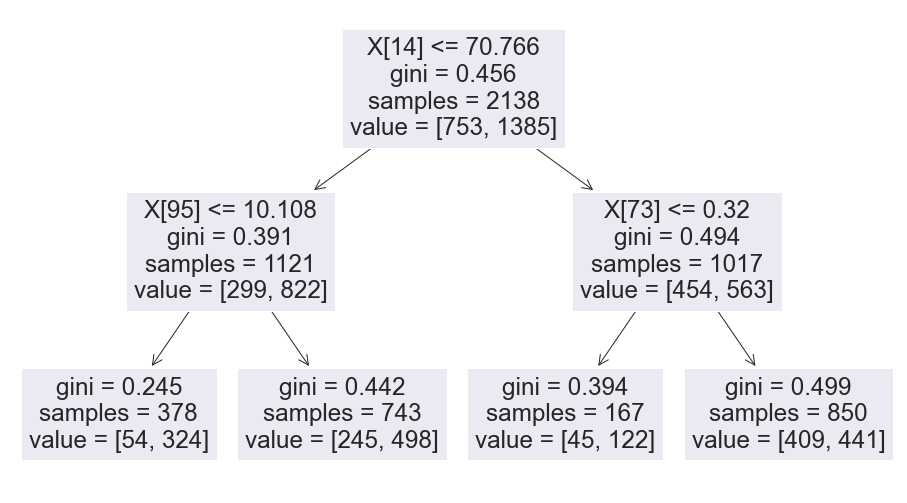

In [61]:
#illustration of the tree
plt.figure(figsize=(16,9))
plot_tree(tree)
plt.show()

In [62]:
#making a prediction for winners, and also a classification report.
y_pred = tree.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       753
         1.0       0.65      1.00      0.79      1385

    accuracy                           0.65      2138
   macro avg       0.32      0.50      0.39      2138
weighted avg       0.42      0.65      0.51      2138



In [63]:
print('Scores for Decision Tree')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for Decision Tree
---------------------------
Baseline score is 0.65
accuracy score is 0.65
precision score is 0.0
recall score is 0.0


# Logistic Regression

In [64]:
#set parameters for logistic regression, fit it, made predictions, and printed training and validate scores.
#they are also better than the baseline, and very close to each other.
logit = LogisticRegression(C= 10, random_state =123)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print(f'training score: {logit.score(X_train, y_train):.2%}')
print(f'validate score: {logit.score(X_validate, y_validate):.2%}')

training score: 67.54%
validate score: 64.56%


In [65]:
#classification report.
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.28      0.38       753
         1.0       0.69      0.89      0.78      1385

    accuracy                           0.68      2138
   macro avg       0.64      0.58      0.58      2138
weighted avg       0.65      0.68      0.64      2138



In [66]:
get_metrics_binary(logit)


    The accuracy for our model is 0.6754
    The True Positive Rate is 0.892, The False Positive Rate is 0.722,
    The True Negative Rate is 0.278, and the False Negative Rate is 0.108
    


precision    recall  f1-score      support
0.0            0.582173  0.277556  0.375899   753.000000
1.0            0.694210  0.891697  0.780657  1385.000000
accuracy       0.675398  0.675398  0.675398     0.675398
macro avg      0.638191  0.584627  0.578278  2138.000000
weighted avg   0.654751  0.675398  0.638102  2138.000000

In [67]:
print('Scores for Logistic Regression!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for Logistic Regression!
---------------------------
Baseline score is 0.65
accuracy score is 0.68
precision score is 0.58
recall score is 0.28


# KNN 

In [68]:
#setting up and fitting my KNN model 
knn = KNeighborsClassifier(n_neighbors = 40)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [69]:
#let's see the training and validate scores
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

training score: 66.04%
validate score: 64.67%


In [70]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.28      0.38       753
         1.0       0.69      0.89      0.78      1385

    accuracy                           0.68      2138
   macro avg       0.64      0.58      0.58      2138
weighted avg       0.65      0.68      0.64      2138



In [71]:
get_metrics_binary(knn)


    The accuracy for our model is 0.6604
    The True Positive Rate is 0.892, The False Positive Rate is 0.722,
    The True Negative Rate is 0.278, and the False Negative Rate is 0.108
    


precision    recall  f1-score      support
0.0            0.582173  0.277556  0.375899   753.000000
1.0            0.694210  0.891697  0.780657  1385.000000
accuracy       0.675398  0.675398  0.675398     0.675398
macro avg      0.638191  0.584627  0.578278  2138.000000
weighted avg   0.654751  0.675398  0.638102  2138.000000

In [72]:
print('Scores for KNN!')
print('---------------------------')
print(f'Baseline score is {baseline_score}')
print(f'accuracy score is {round(sklearn.metrics.accuracy_score(y_train, y_pred),2)}')
print(f'precision score is {round(sklearn.metrics.precision_score(y_train, y_pred, pos_label =0),2)}')
print(f'recall score is {round(sklearn.metrics.recall_score(y_train, y_pred, pos_label =0),2)}')

Scores for KNN!
---------------------------
Baseline score is 0.65
accuracy score is 0.68
precision score is 0.58
recall score is 0.28


In [73]:
# Testing different algorithms/models
use_cross_val = True
dict_model_accuracy = dict()
algorithms = ['knn', 'rfc', 'logistic_regression', 'svm', 'naive_bayes']
for algorithm in algorithms:
    if algorithm == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=55, metric='minkowski', p=10)
    elif algorithm == 'rfc':
        classifier = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=2)
    elif algorithm == 'logistic_regression':
        classifier = LogisticRegression(solver='sag')
    elif algorithm == 'svm':
        classifier = svm.SVC(kernel='rbf')
    elif algorithm == 'naive_bayes':
        classifier = naive_bayes.GaussianNB()

    model = classifier.fit(X_train, y_train)
    
        
        # Evaluate with just the model
    y_pred = model.predict(X_test)
        # cm = confusion_matrix(y_test, y_pred)
    model_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred, normalize=True) * 100
    model_accuracy = round(model_accuracy, 2)
    dict_model_accuracy[algorithm] = model_accuracy
#
rename_dict = {
    'index': 'algorithm',
    0: 'accuracy_percentage'
}
df_accuracies = pd.DataFrame(dict_model_accuracy, index=[0]).T.reset_index().rename(mapper=rename_dict, axis=1)
df_accuracies = df_accuracies.sort_values(by='accuracy_percentage', ascending=False).reset_index(drop=True)

In [74]:
# all algos ran on the test data set
df_accuracies

algorithm  accuracy_percentage
0  logistic_regression                64.14
1                  knn                63.87
2                  rfc                63.35
3                  svm                63.35
4          naive_bayes                59.55

# Conclusion / Next Steps

- Based on the features average submission attempts ,reach ,average significant strikes, 'average ground attempts ,average control time(seconds) there is a 63% accuracy of predicting a winner. 

- My test accuracy of 63% did not beat my baseline of 65% 

- The chart above, I ran my test data on multiple machine learning algo's to get a visual

- With more time I would like to try different combinations or maybe use all the features